In [1]:
%matplotlib notebook
from utils.dataloader import PascalVOCDataset
from utils.dataloader import myimshow
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
import numpy as np
from matplotlib import pyplot as plt
from utils.PositionSensitiveScoreMap import PositionSensitiveScoreMap

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
dataset_root_dir = "/datasets/ee285f-public/PascalVOC2012/"
# dataset_root_dir = "../Datasets/VOCtrainval_11-May-2012/VOCdevkit/VOC2012"

#Creating training and validation sets. Go to utils/dataloader.py for info on important PascalVOCDataset arguments & attributes
train_set = PascalVOCDataset(dataset_root_dir, mode= 'train')
val_set = PascalVOCDataset(dataset_root_dir, mode= 'val')

#Create dataloaders
B = 1
train_loader = td.DataLoader(train_set, batch_size = B, pin_memory = True, shuffle = True)
val_loader = td.DataLoader(val_set, batch_size = B, pin_memory = True)

<IPython.core.display.Javascript object>


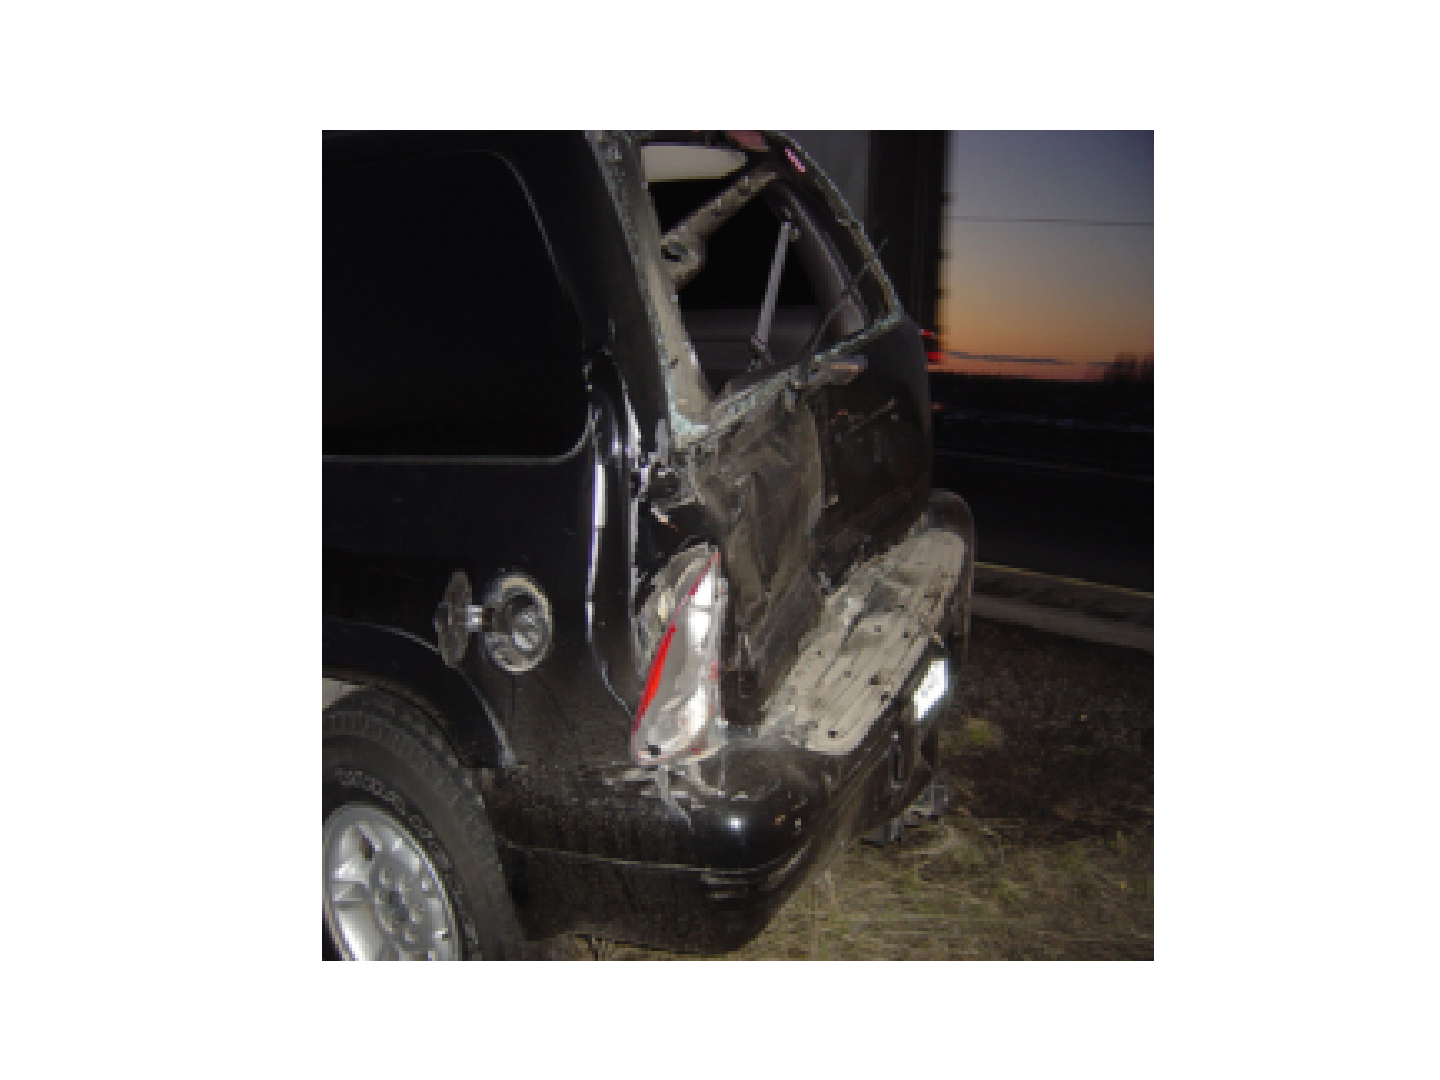

Bounding box corners tensor([[  0,   0, 250, 197]])


In [3]:
#Training set image demo
fig, ax = plt.subplots()
x, bbox, bbox_labels, scale = train_set.__getitem__(15)
h = myimshow(x, ax)

print("Bounding box corners", bbox)

In [5]:
#before running, $cd Multi-Object-Detection/model/utils/nms
#then            $python3 build.py build_ext --inplace

from model.region_proposal_network import RegionProposalNetwork
from model.resnet101extractor import Resnet101Extractor
from model.rfcn_resnet101 import Resnet101RoIHead
from model.rfcn_resnet101 import RFCNResnet101

n_fg_class = 20
feat_stride = 520//16
extractor = Resnet101Extractor().to(device)
rpn = RegionProposalNetwork(in_channels=1024, mid_channels = 1024).to(device)
head = Resnet101RoIHead( #Main class to change
            n_class=n_fg_class + 1,
            roi_size=7,
            spatial_scale=(1. / feat_stride)
        ).to(device)

rfcn = RFCNResnet101().to(device)

/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/model/rfcn_resnet101.py:83: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.cls_layer.weight.data, 0.0, 0.01)
/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/model/rfcn_resnet101.py:87: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.reg_layer.weight.data, 0.0, 0.01)


In [6]:
tensor_im = x.to(device).unsqueeze(0)
out = rfcn(tensor_im)

/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/utils/PositionSensitiveScoreMap_V2.py:60: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = self.softmax(F.adaptive_avg_pool2d(pooling_track.float(),(1,1))[:,:])


In [8]:
from trainer import FasterRCNNTrainer
trainer = FasterRCNNTrainer(rfcn).to(device)
train_loader = td.DataLoader(train_set, batch_size=1, pin_memory = True, shuffle = True)
val_loader  = td.DataLoader(val_set, batch_size=1, pin_memory = True, shuffle = False)

In [ ]:
import time
t = time.time()
img, bboxes, lbls, scale = next(iter(train_loader))
img = img.to(device)
bboxes = bboxes.to(device)
lbls = lbls.to(device)
scale = scale.item()
loss =trainer.train_step(img, bboxes, lbls, scale)
elapsed = time.time() - t
print("Elapsed time: ", elapsed)
print("Loss tuple: ", loss)

/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/utils/PositionSensitiveScoreMap_V2.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = self.softmax(F.adaptive_avg_pool2d(pooling_track.float(),(1,1))[:,:])


LossTuple(rpn_loc_loss=tensor(5.0048, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(4.8224, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(2.2565, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(3.0617, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(15.1455, device='cuda:0', grad_fn=<AddBackward0>))
tensor(15.1455, device='cuda:0', grad_fn=<AddBackward0>)
<class 'torch.Tensor'>
Elapsed time:  2.562675714492798
Loss tuple:  LossTuple(rpn_loc_loss=tensor(5.0048, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(4.8224, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(2.2565, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(3.0617, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(15.1455, device='cuda:0', grad_fn=<AddBackward0>))


In [9]:
out = extractor(tensor_im)

In [28]:
from __future__ import  absolute_import
# though cupy is not used but without this line, it raise errors...
import cupy as cp
import os

import matplotlib
from tqdm import tqdm

import torch as t
from utils.config import opt
from model.rfcn_resnet101 import RFCNResnet101
from torch.utils import data as data_
from trainer import FasterRCNNTrainer
from utils import array_tool as at
from utils.vis_tool import visdom_bbox
from utils.eval_tool import eval_detection_voc

# fix for ulimit
# https://github.com/pytorch/pytorch/issues/973#issuecomment-346405667
import resource

rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (20480, rlimit[1]))

matplotlib.use('agg')


def eval(dataloader, faster_rcnn, test_num=10000):
    gt_difficults = False
    pred_bboxes, pred_labels, pred_scores = list(), list(), list()
    gt_bboxes, gt_labels, gt_difficults = list(), list(), list()
    for ii, (imgs, sizes, gt_bboxes_, gt_labels_) in tqdm(enumerate(dataloader)):
        pred_bboxes_, pred_labels_, pred_scores_ = faster_rcnn.predict(imgs)
        gt_bboxes += list(gt_bboxes_.numpy())
        gt_labels += list(gt_labels_.numpy())
        pred_bboxes += pred_bboxes_
        pred_labels += pred_labels_
        pred_scores += pred_scores_
        if ii == test_num: break

    result = eval_detection_voc(
        pred_bboxes, pred_labels, pred_scores,
        gt_bboxes, gt_labels, gt_difficults,
        use_07_metric=True)
    return result


def train(train_set, val_set, load_path = False, epochs = 1, lr=1e-3, record_every = 300, lr_decay = 1e-3,test_num=500):

    train_dataloader = td.DataLoader(train_set, batch_size = 1, pin_memory = False, shuffle = True)
    test_dataloader = td.DataLoader(val_set, batch_size = 1, pin_memory = True)
    faster_rcnn = RFCNResnet101().cuda()
    print('model construct completed')
    trainer = FasterRCNNTrainer(faster_rcnn).cuda()
    saved_loss = []
    iterations = []
    if load_path:
        trainer.load(load_path)
        print('load pretrained model from %s' % load_path)
        state_dict = t.load(load_path)
        saved_loss = state_dict['losses']
        iterations = state_dict['iterations']
        
    best_map = 0
    lr_ = lr
    for epoch in range(epochs):
        trainer.reset_meters()
        for ii, (img, bbox_, label_, scale) in tqdm(enumerate(train_dataloader)):
            scale = at.scalar(scale)
            img, bbox, label = img.cuda().float(), bbox_.cuda(), label_.cuda()
            losses = trainer.train_step(img, bbox, label, scale)
            loss_info = 'Iter {}; Losses: RPN loc {}, RPN cls: {}, ROI loc {}, ROI cls {}, Total:{}'.format(
                                                str(ii),
                                                "%.3f" % losses[0].cpu().data.numpy(),
                                                "%.3f" % losses[1].cpu().data.numpy(),
                                                "%.3f" % losses[2].cpu().data.numpy(),
                                                "%.3f" % losses[3].cpu().data.numpy(),                                
                                                "%.3f" % losses[4].cpu().data.numpy())
            print(loss_info)
            if (ii + 1) % record_every == 0:
                
                iterations.append(ii + 1) 
                saved_loss.append([losses[0].cpu().data.numpy(),losses[1].cpu().data.numpy(),
                              losses[2].cpu().data.numpy(),losses[3].cpu().data.numpy(),
                              losses[4].cpu().data.numpy()])
                kwargs = {"losses": saved_loss, "iterations": iterations}
                trainer.save(kwargs)
                

In [30]:

train(train_set,val_set, load_path = False, epochs = 1, lr=1e-3, record_every =40)

/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/model/rfcn_resnet101.py:83: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.cls_layer.weight.data, 0.0, 0.01)
/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/model/rfcn_resnet101.py:87: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.reg_layer.weight.data, 0.0, 0.01)
0it [00:00, ?it/s]

model construct completed


/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/utils/PositionSensitiveScoreMap_V2.py:60: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = self.softmax(F.adaptive_avg_pool2d(pooling_track.float(),(1,1))[:,:])
1it [00:00,  1.35it/s]

Iter 0; Losses: RPN loc 11.8355, RPN cls: 1.9032, ROI loc 20.6643, ROI cls 3.0841, Total:37.4872


/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/model/utils/bbox_tools.py:69: RuntimeWarning: overflow encountered in multiply
  w = xp.exp(dw) * src_width[:, xp.newaxis]
2it [00:01,  1.54it/s]

Iter 1; Losses: RPN loc 8.5648, RPN cls: 23.2731, ROI loc 100.9865, ROI cls 3.0039, Total:135.8282


/datasets/home/home-02/50/150/prvo/Multi-Object-Detection/model/utils/bbox_tools.py:68: RuntimeWarning: overflow encountered in multiply
  h = xp.exp(dh) * src_height[:, xp.newaxis]
3it [00:01,  1.80it/s]

Iter 2; Losses: RPN loc 7.8322, RPN cls: 29.0642, ROI loc 178.4571, ROI cls 2.7675, Total:218.1209


4it [00:02,  1.63it/s]

Iter 3; Losses: RPN loc 762.4644, RPN cls: 400.0385, ROI loc 630.7748, ROI cls 2.9658, Total:1796.2437


5it [00:03,  1.43it/s]

Iter 4; Losses: RPN loc 26.8024, RPN cls: 6.5437, ROI loc 16.3026, ROI cls 2.2992, Total:51.9478


6it [00:04,  1.09it/s]

Iter 5; Losses: RPN loc 27.5711, RPN cls: 0.5144, ROI loc 172.1894, ROI cls 2.2811, Total:202.5560


7it [00:06,  1.32s/it]

Iter 6; Losses: RPN loc 18.8648, RPN cls: 0.4337, ROI loc 558.7438, ROI cls 2.4346, Total:580.4769


8it [00:08,  1.43s/it]

Iter 7; Losses: RPN loc 3.4193, RPN cls: 2.1452, ROI loc 40.2301, ROI cls 2.1470, Total:47.9416


9it [00:09,  1.24s/it]

Iter 8; Losses: RPN loc 16.4587, RPN cls: 14.7336, ROI loc 155.4300, ROI cls 2.2811, Total:188.9034


10it [00:10,  1.35s/it]

Iter 9; Losses: RPN loc 2.9477, RPN cls: 1.3599, ROI loc 22.2344, ROI cls 2.1946, Total:28.7367


11it [00:12,  1.36s/it]

Iter 10; Losses: RPN loc 16.3854, RPN cls: 18.3576, ROI loc 37.0934, ROI cls 2.2089, Total:74.0452


12it [00:14,  1.57s/it]

Iter 11; Losses: RPN loc 2.1825, RPN cls: 12.0843, ROI loc 17.5612, ROI cls 2.1420, Total:33.9701


13it [00:15,  1.40s/it]

Iter 12; Losses: RPN loc 19.7233, RPN cls: 30.0924, ROI loc 125.8153, ROI cls 2.2032, Total:177.8342


14it [00:19,  2.21s/it]

Iter 13; Losses: RPN loc 1.1121, RPN cls: 0.6987, ROI loc 155.2006, ROI cls 2.2343, Total:159.2457


15it [00:23,  2.86s/it]

Iter 14; Losses: RPN loc 1.5710, RPN cls: 0.8463, ROI loc 79.5348, ROI cls 2.1963, Total:84.1485


16it [00:28,  3.35s/it]

Iter 15; Losses: RPN loc 0.7028, RPN cls: 0.7363, ROI loc 92.0187, ROI cls 2.2013, Total:95.6590


17it [00:33,  3.75s/it]

Iter 16; Losses: RPN loc 0.0372, RPN cls: 0.6208, ROI loc 35.0944, ROI cls 2.1857, Total:37.9380


18it [00:37,  4.01s/it]

Iter 17; Losses: RPN loc 0.6293, RPN cls: 0.6273, ROI loc 4.6482, ROI cls 2.1857, Total:8.0905


19it [00:42,  4.14s/it]

Iter 18; Losses: RPN loc 0.1106, RPN cls: 0.5447, ROI loc 38.7884, ROI cls 2.1622, Total:41.6059


20it [00:46,  4.24s/it]

Iter 19; Losses: RPN loc 0.2304, RPN cls: 0.4776, ROI loc 48.2274, ROI cls 2.1935, Total:51.1288


21it [00:50,  4.28s/it]

Iter 20; Losses: RPN loc 0.4931, RPN cls: 0.7940, ROI loc 70.5147, ROI cls 2.1935, Total:73.9952


22it [00:55,  4.29s/it]

Iter 21; Losses: RPN loc 1.1931, RPN cls: 1.2026, ROI loc 60.7243, ROI cls 2.2025, Total:65.3226


23it [00:59,  4.32s/it]

Iter 22; Losses: RPN loc 0.0074, RPN cls: 0.6480, ROI loc 11.1343, ROI cls 2.1388, Total:13.9285


24it [01:04,  4.39s/it]

Iter 23; Losses: RPN loc 0.0797, RPN cls: 0.6527, ROI loc 23.0242, ROI cls 2.2091, Total:25.9657


25it [01:08,  4.41s/it]

Iter 24; Losses: RPN loc 0.5043, RPN cls: 0.6091, ROI loc 14.5555, ROI cls 2.1310, Total:17.7999


26it [01:12,  4.33s/it]

Iter 25; Losses: RPN loc 0.2436, RPN cls: 0.5136, ROI loc 2.5764, ROI cls 2.1310, Total:5.4645


27it [01:17,  4.30s/it]

Iter 26; Losses: RPN loc 0.4281, RPN cls: 0.6701, ROI loc 14.2697, ROI cls 2.1466, Total:17.5145


28it [01:21,  4.28s/it]

Iter 27; Losses: RPN loc 0.5071, RPN cls: 0.7367, ROI loc 109.3626, ROI cls 2.2482, Total:112.8546


29it [01:25,  4.31s/it]

Iter 28; Losses: RPN loc 0.1898, RPN cls: 0.2701, ROI loc 28.6916, ROI cls 2.1622, Total:31.3138


30it [01:30,  4.41s/it]

Iter 29; Losses: RPN loc 1.7506, RPN cls: 1.8774, ROI loc 44.3854, ROI cls 2.1544, Total:50.1678


31it [01:35,  4.62s/it]

Iter 30; Losses: RPN loc 0.2202, RPN cls: 1.0962, ROI loc 31.5589, ROI cls 2.2247, Total:35.1001


32it [01:39,  4.61s/it]

Iter 31; Losses: RPN loc 0.0851, RPN cls: 0.5309, ROI loc 13.4312, ROI cls 2.1935, Total:16.2406


33it [01:44,  4.61s/it]

Iter 32; Losses: RPN loc 1.7300, RPN cls: 0.6246, ROI loc 6.6894, ROI cls 2.1310, Total:11.1750


34it [01:49,  4.62s/it]

Iter 33; Losses: RPN loc 2.5574, RPN cls: 0.9984, ROI loc 91.2973, ROI cls 2.2482, Total:97.1012


35it [01:53,  4.54s/it]

Iter 34; Losses: RPN loc 0.0758, RPN cls: 0.7676, ROI loc 54.2511, ROI cls 2.1779, Total:57.2723


36it [01:57,  4.47s/it]

Iter 35; Losses: RPN loc 0.4516, RPN cls: 0.6689, ROI loc 54.4017, ROI cls 2.2013, Total:57.7235


37it [02:02,  4.43s/it]

Iter 36; Losses: RPN loc 0.3756, RPN cls: 0.6758, ROI loc 43.8335, ROI cls 2.2091, Total:47.0939


38it [02:06,  4.50s/it]

Iter 37; Losses: RPN loc 0.3333, RPN cls: 0.7080, ROI loc 18.6687, ROI cls 2.1700, Total:21.8800


39it [02:11,  4.57s/it]

Iter 38; Losses: RPN loc 0.0847, RPN cls: 0.6438, ROI loc 2.5749, ROI cls 2.1310, Total:5.4343


40it [02:16,  4.65s/it]

Iter 39; Losses: RPN loc 0.0650, RPN cls: 0.6208, ROI loc 3.2460, ROI cls 2.1310, Total:6.0628


41it [02:21,  4.64s/it]

Iter 40; Losses: RPN loc 0.1119, RPN cls: 0.5214, ROI loc 2.7211, ROI cls 2.1310, Total:5.4854


42it [02:25,  4.60s/it]

Iter 41; Losses: RPN loc 0.2497, RPN cls: 0.5931, ROI loc 65.2495, ROI cls 2.1857, Total:68.2780


43it [02:30,  4.62s/it]

Iter 42; Losses: RPN loc 0.0229, RPN cls: 0.5146, ROI loc 105.7073, ROI cls 2.1935, Total:108.4382


44it [02:34,  4.59s/it]

Iter 43; Losses: RPN loc 0.0128, RPN cls: 0.4209, ROI loc 21.0914, ROI cls 2.1388, Total:23.6638


45it [02:39,  4.51s/it]

Iter 44; Losses: RPN loc 0.2550, RPN cls: 0.3611, ROI loc 70.5918, ROI cls 2.1935, Total:73.4014


46it [02:43,  4.53s/it]

Iter 45; Losses: RPN loc 0.5251, RPN cls: 0.3090, ROI loc 26.9152, ROI cls 2.1622, Total:29.9116


47it [02:48,  4.60s/it]

Iter 46; Losses: RPN loc 0.4138, RPN cls: 0.5739, ROI loc 31.7823, ROI cls 2.1935, Total:34.9634


48it [02:53,  4.63s/it]

Iter 47; Losses: RPN loc 0.3705, RPN cls: 0.7191, ROI loc 37.2408, ROI cls 2.2950, Total:40.6255


49it [02:57,  4.70s/it]

Iter 48; Losses: RPN loc 0.5723, RPN cls: 0.5787, ROI loc 37.0611, ROI cls 2.2169, Total:40.4291


50it [03:02,  4.70s/it]

Iter 49; Losses: RPN loc 0.4564, RPN cls: 0.5051, ROI loc 74.7284, ROI cls 2.2169, Total:77.9069


51it [03:07,  4.70s/it]

Iter 50; Losses: RPN loc 0.5593, RPN cls: 0.7178, ROI loc 63.1529, ROI cls 2.2091, Total:66.6391


52it [03:11,  4.67s/it]

Iter 51; Losses: RPN loc 0.2387, RPN cls: 0.5551, ROI loc 68.1399, ROI cls 2.2091, Total:71.1428


53it [03:16,  4.74s/it]

Iter 52; Losses: RPN loc 0.5985, RPN cls: 0.8461, ROI loc 71.6111, ROI cls 2.2872, Total:75.3429


54it [03:22,  4.87s/it]

Iter 53; Losses: RPN loc 0.1087, RPN cls: 0.8318, ROI loc 43.4716, ROI cls 2.2404, Total:46.6525


55it [03:26,  4.88s/it]

Iter 54; Losses: RPN loc 0.6252, RPN cls: 0.6861, ROI loc 19.3764, ROI cls 2.1622, Total:22.8500


56it [03:31,  4.81s/it]

Iter 55; Losses: RPN loc 0.8043, RPN cls: 0.6949, ROI loc 59.2134, ROI cls 2.2247, Total:62.9373


57it [03:36,  4.82s/it]

Iter 56; Losses: RPN loc 0.6578, RPN cls: 0.7367, ROI loc 117.2072, ROI cls 2.3263, Total:120.9280


58it [03:40,  4.60s/it]

Iter 57; Losses: RPN loc 0.1771, RPN cls: 0.7250, ROI loc 71.3597, ROI cls 2.2503, Total:74.5120


59it [03:45,  4.57s/it]

Iter 58; Losses: RPN loc 0.1630, RPN cls: 0.6322, ROI loc 13.9400, ROI cls 2.1857, Total:16.9208


60it [03:49,  4.59s/it]

Iter 59; Losses: RPN loc 0.3488, RPN cls: 0.6070, ROI loc 11.6990, ROI cls 2.1544, Total:14.8093


61it [03:54,  4.52s/it]

Iter 60; Losses: RPN loc 0.6832, RPN cls: 0.7796, ROI loc 89.9139, ROI cls 2.2950, Total:93.6717


62it [03:58,  4.53s/it]

Iter 61; Losses: RPN loc 0.0256, RPN cls: 0.5824, ROI loc 4.2927, ROI cls 2.1310, Total:7.0317


63it [04:03,  4.54s/it]

Iter 62; Losses: RPN loc 0.4776, RPN cls: 0.6265, ROI loc 50.8920, ROI cls 2.2482, Total:54.2443


64it [04:07,  4.44s/it]

Iter 63; Losses: RPN loc 0.0092, RPN cls: 0.6429, ROI loc 24.3228, ROI cls 2.1560, Total:27.1309


65it [04:12,  4.52s/it]

Iter 64; Losses: RPN loc 0.2132, RPN cls: 0.7848, ROI loc 17.9565, ROI cls 2.1700, Total:21.1245


66it [04:16,  4.54s/it]

Iter 65; Losses: RPN loc 0.0990, RPN cls: 0.6311, ROI loc 39.2323, ROI cls 2.2105, Total:42.1728


67it [04:21,  4.52s/it]

Iter 66; Losses: RPN loc 0.1789, RPN cls: 0.6556, ROI loc 33.9821, ROI cls 2.2169, Total:37.0334


68it [04:25,  4.41s/it]

Iter 67; Losses: RPN loc 0.6186, RPN cls: 0.6932, ROI loc 30.0016, ROI cls 2.2543, Total:33.5678


69it [04:29,  4.37s/it]

Iter 68; Losses: RPN loc 0.2587, RPN cls: 0.6666, ROI loc 8.1379, ROI cls 2.1388, Total:11.2021


70it [04:34,  4.41s/it]

Iter 69; Losses: RPN loc 0.5418, RPN cls: 0.6950, ROI loc 53.3778, ROI cls 2.2325, Total:56.8471


71it [04:39,  4.69s/it]

Iter 70; Losses: RPN loc 0.2602, RPN cls: 0.6766, ROI loc 45.0846, ROI cls 2.1982, Total:48.2196


72it [04:44,  4.87s/it]

Iter 71; Losses: RPN loc 0.7741, RPN cls: 0.7250, ROI loc 146.4366, ROI cls 2.3732, Total:150.3088


73it [04:49,  4.79s/it]

Iter 72; Losses: RPN loc 0.8958, RPN cls: 0.6741, ROI loc 2.9515, ROI cls 2.1314, Total:6.6527


74it [04:53,  4.64s/it]

Iter 73; Losses: RPN loc 0.7004, RPN cls: 0.7133, ROI loc 73.6104, ROI cls 2.3732, Total:77.3972


75it [04:58,  4.58s/it]

Iter 74; Losses: RPN loc 0.5825, RPN cls: 0.6855, ROI loc 42.3800, ROI cls 2.2058, Total:45.8538


76it [05:02,  4.55s/it]

Iter 75; Losses: RPN loc 0.2296, RPN cls: 0.6683, ROI loc 25.1110, ROI cls 2.1862, Total:28.1950


77it [05:07,  4.64s/it]

Iter 76; Losses: RPN loc 0.3172, RPN cls: 0.6865, ROI loc 55.4085, ROI cls 2.2169, Total:58.6291


78it [05:11,  4.62s/it]

Iter 77; Losses: RPN loc 0.1686, RPN cls: 0.6736, ROI loc 31.7683, ROI cls 2.1801, Total:34.7906


79it [05:16,  4.59s/it]

Iter 78; Losses: RPN loc 0.3813, RPN cls: 0.6801, ROI loc 50.8125, ROI cls 2.2025, Total:54.0765


80it [05:20,  4.54s/it]

Iter 79; Losses: RPN loc 0.7476, RPN cls: 0.7361, ROI loc 96.6709, ROI cls 2.3315, Total:100.4860


81it [05:25,  4.47s/it]

Iter 80; Losses: RPN loc 0.4637, RPN cls: 0.6665, ROI loc 53.9161, ROI cls 2.3185, Total:57.3648


82it [05:29,  4.49s/it]

Iter 81; Losses: RPN loc 0.3727, RPN cls: 0.6944, ROI loc 50.7130, ROI cls 2.2413, Total:54.0214


83it [05:33,  4.42s/it]

Iter 82; Losses: RPN loc 0.1348, RPN cls: 0.6264, ROI loc 63.2664, ROI cls 2.1975, Total:66.2252


84it [05:38,  4.44s/it]

Iter 83; Losses: RPN loc 0.1371, RPN cls: 0.6221, ROI loc 89.5456, ROI cls 2.1988, Total:92.5036


85it [05:43,  4.50s/it]

Iter 84; Losses: RPN loc 2.0448, RPN cls: 0.9641, ROI loc 76.2036, ROI cls 2.1935, Total:81.4060


86it [05:47,  4.51s/it]

Iter 85; Losses: RPN loc 0.2346, RPN cls: 0.6714, ROI loc 83.5490, ROI cls 2.1893, Total:86.6443


87it [05:51,  4.40s/it]

Iter 86; Losses: RPN loc 0.1444, RPN cls: 0.6700, ROI loc 82.1066, ROI cls 2.2164, Total:85.1373


88it [05:56,  4.41s/it]

Iter 87; Losses: RPN loc 0.5327, RPN cls: 0.6963, ROI loc 54.5725, ROI cls 2.2051, Total:58.0065


89it [06:00,  4.47s/it]

Iter 88; Losses: RPN loc 0.1129, RPN cls: 0.6525, ROI loc 7.5904, ROI cls 2.1312, Total:10.4871


90it [06:04,  4.33s/it]

Iter 89; Losses: RPN loc 0.0311, RPN cls: 0.6485, ROI loc 40.4729, ROI cls 2.1857, Total:43.3382


91it [06:08,  4.27s/it]

Iter 90; Losses: RPN loc 0.0759, RPN cls: 0.6515, ROI loc 5.7872, ROI cls 2.1319, Total:8.6465


92it [06:12,  4.20s/it]

Iter 91; Losses: RPN loc 0.0161, RPN cls: 0.6498, ROI loc 13.4364, ROI cls 2.1560, Total:16.2582


93it [06:17,  4.16s/it]

Iter 92; Losses: RPN loc 0.1257, RPN cls: 0.6543, ROI loc 8.5518, ROI cls 2.1312, Total:11.4630


94it [06:21,  4.35s/it]

Iter 93; Losses: RPN loc 0.5649, RPN cls: 0.6669, ROI loc 10.7814, ROI cls 2.1310, Total:14.1442


95it [06:26,  4.31s/it]

Iter 94; Losses: RPN loc 0.3487, RPN cls: 0.6500, ROI loc 7.2465, ROI cls 2.1315, Total:10.3768


96it [06:30,  4.35s/it]

Iter 95; Losses: RPN loc 0.0994, RPN cls: 0.6530, ROI loc 8.5539, ROI cls 2.1315, Total:11.4378


97it [06:34,  4.34s/it]

Iter 96; Losses: RPN loc 0.0098, RPN cls: 0.6396, ROI loc 103.7490, ROI cls 2.2197, Total:106.6181


98it [06:39,  4.30s/it]

Iter 97; Losses: RPN loc 0.0538, RPN cls: 0.6420, ROI loc 45.0261, ROI cls 2.1732, Total:47.8951


99it [06:43,  4.27s/it]

Iter 98; Losses: RPN loc 0.3545, RPN cls: 0.6839, ROI loc 68.4056, ROI cls 2.2408, Total:71.6848


100it [06:47,  4.36s/it]

Iter 99; Losses: RPN loc 0.0095, RPN cls: 0.6308, ROI loc 68.2702, ROI cls 2.2461, Total:71.1567


101it [06:51,  4.29s/it]

Iter 100; Losses: RPN loc 0.0506, RPN cls: 0.6418, ROI loc 55.6458, ROI cls 2.2257, Total:58.5640


102it [06:56,  4.38s/it]

Iter 101; Losses: RPN loc 0.0398, RPN cls: 0.6436, ROI loc 35.7443, ROI cls 2.1969, Total:38.6246


103it [07:00,  4.33s/it]

Iter 102; Losses: RPN loc 0.1188, RPN cls: 0.6603, ROI loc 154.8219, ROI cls 2.3006, Total:157.9016


104it [07:05,  4.41s/it]

Iter 103; Losses: RPN loc 0.0754, RPN cls: 0.6580, ROI loc 73.2440, ROI cls 2.2098, Total:76.1872


105it [07:10,  4.53s/it]

Iter 104; Losses: RPN loc 0.1260, RPN cls: 0.6377, ROI loc 4.8990, ROI cls 2.1316, Total:7.7944


106it [07:14,  4.48s/it]

Iter 105; Losses: RPN loc 0.2368, RPN cls: 0.6820, ROI loc 81.3887, ROI cls 2.3117, Total:84.6192


107it [07:18,  4.45s/it]

Iter 106; Losses: RPN loc 0.0502, RPN cls: 0.6314, ROI loc 41.7152, ROI cls 2.2188, Total:44.6157


108it [07:23,  4.53s/it]

Iter 107; Losses: RPN loc 0.5161, RPN cls: 0.6672, ROI loc 42.5565, ROI cls 2.2019, Total:45.9417


109it [07:28,  4.69s/it]

Iter 108; Losses: RPN loc 0.5664, RPN cls: 0.7582, ROI loc 194.9530, ROI cls 2.3855, Total:198.6631


110it [07:33,  4.85s/it]

Iter 109; Losses: RPN loc 0.3181, RPN cls: 0.6377, ROI loc 16.4833, ROI cls 2.1394, Total:19.5784


111it [07:38,  4.69s/it]

Iter 110; Losses: RPN loc 0.5529, RPN cls: 0.6479, ROI loc 14.4757, ROI cls 2.1482, Total:17.8246


112it [07:42,  4.61s/it]

Iter 111; Losses: RPN loc 0.0779, RPN cls: 0.6411, ROI loc 145.2895, ROI cls 2.3215, Total:148.3300


113it [07:47,  4.62s/it]

Iter 112; Losses: RPN loc 0.8764, RPN cls: 0.6907, ROI loc 46.0739, ROI cls 2.1632, Total:49.8041


114it [07:51,  4.55s/it]

Iter 113; Losses: RPN loc 0.4162, RPN cls: 0.7234, ROI loc 97.1989, ROI cls 2.2728, Total:100.6114


115it [07:55,  4.44s/it]

Iter 114; Losses: RPN loc 0.2311, RPN cls: 0.6977, ROI loc 93.9706, ROI cls 2.2707, Total:97.1701


116it [07:59,  4.34s/it]

Iter 115; Losses: RPN loc 0.0674, RPN cls: 0.6173, ROI loc 3.9538, ROI cls 2.1318, Total:6.7703


117it [08:04,  4.35s/it]

Iter 116; Losses: RPN loc 0.2490, RPN cls: 0.6263, ROI loc 2.5103, ROI cls 2.1315, Total:5.5171


118it [08:08,  4.38s/it]

Iter 117; Losses: RPN loc 0.0860, RPN cls: 0.6731, ROI loc 57.9329, ROI cls 2.3035, Total:60.9955


119it [08:13,  4.35s/it]

Iter 118; Losses: RPN loc 0.1859, RPN cls: 0.6503, ROI loc 16.2534, ROI cls 2.2172, Total:19.3068


120it [08:17,  4.35s/it]

Iter 119; Losses: RPN loc 0.1530, RPN cls: 0.6407, ROI loc 54.6402, ROI cls 2.2625, Total:57.6964


121it [08:21,  4.35s/it]

Iter 120; Losses: RPN loc 0.3340, RPN cls: 0.6520, ROI loc 21.3237, ROI cls 2.2058, Total:24.5155


122it [08:25,  4.29s/it]

Iter 121; Losses: RPN loc 1.6281, RPN cls: 0.6805, ROI loc 22.2919, ROI cls 2.1560, Total:26.7565


123it [08:30,  4.36s/it]

Iter 122; Losses: RPN loc 0.3737, RPN cls: 0.6831, ROI loc 67.0471, ROI cls 2.2716, Total:70.3755


124it [08:34,  4.35s/it]

Iter 123; Losses: RPN loc 0.0091, RPN cls: 0.6121, ROI loc 22.8234, ROI cls 2.1704, Total:25.6150


125it [08:39,  4.34s/it]

Iter 124; Losses: RPN loc 0.9592, RPN cls: 0.7956, ROI loc 76.1576, ROI cls 2.3732, Total:80.2855


126it [08:43,  4.40s/it]

Iter 125; Losses: RPN loc 0.2644, RPN cls: 0.6985, ROI loc 77.5114, ROI cls 2.3380, Total:80.8123


127it [08:48,  4.52s/it]

Iter 126; Losses: RPN loc 0.3630, RPN cls: 0.6977, ROI loc 57.6575, ROI cls 2.2764, Total:60.9946


128it [08:53,  4.66s/it]

Iter 127; Losses: RPN loc 0.3654, RPN cls: 0.6593, ROI loc 24.2549, ROI cls 2.2091, Total:27.4888


129it [08:57,  4.60s/it]

Iter 128; Losses: RPN loc 0.0581, RPN cls: 0.5919, ROI loc 3.2940, ROI cls 2.1311, Total:6.0752


130it [09:02,  4.51s/it]

Iter 129; Losses: RPN loc 1.2814, RPN cls: 0.6872, ROI loc 17.4817, ROI cls 2.1474, Total:21.5978


131it [09:06,  4.48s/it]

Iter 130; Losses: RPN loc 0.9851, RPN cls: 0.7550, ROI loc 49.8159, ROI cls 2.2471, Total:53.8031


132it [09:11,  4.46s/it]

Iter 131; Losses: RPN loc 0.7976, RPN cls: 0.7062, ROI loc 53.5575, ROI cls 2.2789, Total:57.3401


133it [09:15,  4.43s/it]

Iter 132; Losses: RPN loc 1.3294, RPN cls: 0.6664, ROI loc 4.8968, ROI cls 2.1484, Total:9.0410


134it [09:19,  4.46s/it]

Iter 133; Losses: RPN loc 0.0559, RPN cls: 0.6128, ROI loc 3.8357, ROI cls 2.1315, Total:6.6359


135it [09:24,  4.52s/it]

Iter 134; Losses: RPN loc 0.9051, RPN cls: 0.7661, ROI loc 32.7393, ROI cls 2.2141, Total:36.6246


136it [09:29,  4.56s/it]

Iter 135; Losses: RPN loc 0.1470, RPN cls: 0.6407, ROI loc 26.8937, ROI cls 2.2105, Total:29.8919


137it [09:33,  4.41s/it]

Iter 136; Losses: RPN loc 0.2204, RPN cls: 0.6895, ROI loc 38.1705, ROI cls 2.2770, Total:41.3574


138it [09:37,  4.46s/it]

Iter 137; Losses: RPN loc 0.1434, RPN cls: 0.6502, ROI loc 19.8463, ROI cls 2.1898, Total:22.8298


139it [09:41,  4.36s/it]

Iter 138; Losses: RPN loc 0.9140, RPN cls: 0.7769, ROI loc 86.9592, ROI cls 2.3050, Total:90.9551


140it [09:46,  4.37s/it]

Iter 139; Losses: RPN loc 0.3173, RPN cls: 0.6538, ROI loc 9.0677, ROI cls 2.1393, Total:12.1781


141it [09:50,  4.34s/it]

Iter 140; Losses: RPN loc 0.4541, RPN cls: 0.6659, ROI loc 29.8338, ROI cls 2.2180, Total:33.1718


142it [09:55,  4.36s/it]

Iter 141; Losses: RPN loc 0.4268, RPN cls: 0.6862, ROI loc 9.9138, ROI cls 2.2156, Total:13.2424


143it [09:59,  4.32s/it]

Iter 142; Losses: RPN loc 0.4669, RPN cls: 0.6843, ROI loc 37.1863, ROI cls 2.2492, Total:40.5867


144it [10:04,  4.45s/it]

Iter 143; Losses: RPN loc 0.1792, RPN cls: 0.6499, ROI loc 22.2376, ROI cls 2.1940, Total:25.2608


145it [10:08,  4.47s/it]

Iter 144; Losses: RPN loc 0.4666, RPN cls: 0.7018, ROI loc 34.9800, ROI cls 2.2091, Total:38.3575


146it [10:13,  4.49s/it]

Iter 145; Losses: RPN loc 0.1127, RPN cls: 0.5585, ROI loc 28.2633, ROI cls 2.2086, Total:31.1432


147it [10:17,  4.51s/it]

Iter 146; Losses: RPN loc 0.3985, RPN cls: 0.6642, ROI loc 32.4388, ROI cls 2.1779, Total:35.6793


148it [10:21,  4.44s/it]

Iter 147; Losses: RPN loc 0.0692, RPN cls: 0.5937, ROI loc 36.0961, ROI cls 2.2119, Total:38.9709


149it [10:26,  4.39s/it]

Iter 148; Losses: RPN loc 0.1565, RPN cls: 0.5421, ROI loc 26.0182, ROI cls 2.1857, Total:28.9025


150it [10:30,  4.44s/it]

Iter 149; Losses: RPN loc 0.6503, RPN cls: 0.4461, ROI loc 58.3931, ROI cls 2.3263, Total:61.8159


151it [10:34,  4.38s/it]

Iter 150; Losses: RPN loc 0.1029, RPN cls: 0.4905, ROI loc 15.2692, ROI cls 2.1872, Total:18.0497


152it [10:39,  4.47s/it]

Iter 151; Losses: RPN loc 1.0430, RPN cls: 1.1689, ROI loc 57.5907, ROI cls 2.1700, Total:61.9726


153it [10:44,  4.44s/it]

Iter 152; Losses: RPN loc 0.2352, RPN cls: 0.6518, ROI loc 76.8741, ROI cls 2.2045, Total:79.9655


154it [10:48,  4.36s/it]

Iter 153; Losses: RPN loc 0.2000, RPN cls: 0.6657, ROI loc 77.3498, ROI cls 2.2101, Total:80.4256


155it [10:52,  4.29s/it]

Iter 154; Losses: RPN loc 0.0241, RPN cls: 0.6038, ROI loc 39.5752, ROI cls 2.1635, Total:42.3666


156it [10:56,  4.21s/it]

Iter 155; Losses: RPN loc 0.3964, RPN cls: 0.6846, ROI loc 46.2252, ROI cls 2.2051, Total:49.5113


157it [11:00,  4.17s/it]

Iter 156; Losses: RPN loc 0.5333, RPN cls: 0.6501, ROI loc 38.0544, ROI cls 2.2014, Total:41.4392


158it [11:05,  4.29s/it]

Iter 157; Losses: RPN loc 0.0737, RPN cls: 0.6211, ROI loc 69.9920, ROI cls 2.2819, Total:72.9686


159it [11:09,  4.31s/it]

Iter 158; Losses: RPN loc 0.0569, RPN cls: 0.5946, ROI loc 47.8599, ROI cls 2.2297, Total:50.7411


160it [11:13,  4.36s/it]

Iter 159; Losses: RPN loc 0.7588, RPN cls: 0.7297, ROI loc 24.6650, ROI cls 2.1975, Total:28.3510


161it [11:17,  4.23s/it]

Iter 160; Losses: RPN loc 0.0077, RPN cls: 0.5026, ROI loc 13.4216, ROI cls 2.1577, Total:16.0896


162it [11:21,  4.19s/it]

Iter 161; Losses: RPN loc 0.4633, RPN cls: 0.6356, ROI loc 12.3551, ROI cls 2.1318, Total:15.5858


163it [11:26,  4.37s/it]

Iter 162; Losses: RPN loc 0.0506, RPN cls: 0.5881, ROI loc 83.7573, ROI cls 2.2045, Total:86.6005


164it [11:31,  4.38s/it]

Iter 163; Losses: RPN loc 0.7797, RPN cls: 0.7612, ROI loc 110.2560, ROI cls 2.2471, Total:114.0440


165it [11:35,  4.38s/it]

Iter 164; Losses: RPN loc 0.4566, RPN cls: 0.6645, ROI loc 77.4559, ROI cls 2.2126, Total:80.7897


166it [11:39,  4.39s/it]

Iter 165; Losses: RPN loc 0.1402, RPN cls: 0.6160, ROI loc 49.0456, ROI cls 2.1933, Total:51.9951


167it [11:44,  4.39s/it]

Iter 166; Losses: RPN loc 0.9638, RPN cls: 0.6707, ROI loc 29.2588, ROI cls 2.1554, Total:33.0486


168it [11:48,  4.47s/it]

Iter 167; Losses: RPN loc 0.1773, RPN cls: 0.5952, ROI loc 20.7375, ROI cls 2.1472, Total:23.6572


169it [11:53,  4.50s/it]

Iter 168; Losses: RPN loc 0.0061, RPN cls: 0.5919, ROI loc 55.3351, ROI cls 2.2141, Total:58.1472


170it [11:57,  4.43s/it]

Iter 169; Losses: RPN loc 0.3350, RPN cls: 0.7022, ROI loc 101.3863, ROI cls 2.2588, Total:104.6823


171it [12:01,  4.36s/it]

Iter 170; Losses: RPN loc 0.2826, RPN cls: 0.6418, ROI loc 60.6522, ROI cls 2.2172, Total:63.7938


172it [12:05,  4.23s/it]

Iter 171; Losses: RPN loc 0.0906, RPN cls: 0.6267, ROI loc 52.1726, ROI cls 2.2149, Total:55.1049


173it [12:10,  4.25s/it]

Iter 172; Losses: RPN loc 0.2601, RPN cls: 0.6583, ROI loc 69.3578, ROI cls 2.2868, Total:72.5630


174it [12:14,  4.34s/it]

Iter 173; Losses: RPN loc 0.2265, RPN cls: 0.6780, ROI loc 78.8903, ROI cls 2.2806, Total:82.0755


175it [12:19,  4.40s/it]

Iter 174; Losses: RPN loc 0.0116, RPN cls: 0.5955, ROI loc 40.8902, ROI cls 2.2223, Total:43.7196


176it [12:23,  4.43s/it]

Iter 175; Losses: RPN loc 0.0656, RPN cls: 0.6098, ROI loc 33.1812, ROI cls 2.2148, Total:36.0713


177it [12:28,  4.46s/it]

Iter 176; Losses: RPN loc 0.5467, RPN cls: 0.7173, ROI loc 86.1751, ROI cls 2.3183, Total:89.7575


178it [12:32,  4.46s/it]

Iter 177; Losses: RPN loc 0.3072, RPN cls: 0.6433, ROI loc 22.7846, ROI cls 2.2094, Total:25.9445


179it [12:36,  4.24s/it]

Iter 178; Losses: RPN loc 1.9082, RPN cls: 0.6898, ROI loc 5.2635, ROI cls 2.1325, Total:9.9939


180it [12:40,  4.14s/it]

Iter 179; Losses: RPN loc 0.3188, RPN cls: 0.6870, ROI loc 51.8977, ROI cls 2.2362, Total:55.1397


181it [12:44,  4.20s/it]

Iter 180; Losses: RPN loc 0.4617, RPN cls: 0.7085, ROI loc 16.2437, ROI cls 2.1825, Total:19.5965


182it [12:49,  4.25s/it]

Iter 181; Losses: RPN loc 0.1407, RPN cls: 0.6164, ROI loc 51.1792, ROI cls 2.2898, Total:54.2262


183it [12:53,  4.17s/it]

Iter 182; Losses: RPN loc 1.0141, RPN cls: 0.8265, ROI loc 31.2329, ROI cls 2.2777, Total:35.3512


184it [12:57,  4.19s/it]

Iter 183; Losses: RPN loc 0.3468, RPN cls: 0.6445, ROI loc 33.7187, ROI cls 2.2275, Total:36.9374


185it [13:01,  4.15s/it]

Iter 184; Losses: RPN loc 0.0720, RPN cls: 0.6224, ROI loc 88.6895, ROI cls 2.3269, Total:91.7107


186it [13:05,  4.15s/it]

Iter 185; Losses: RPN loc 0.0671, RPN cls: 0.6215, ROI loc 39.8559, ROI cls 2.2172, Total:42.7617


187it [13:09,  4.20s/it]

Iter 186; Losses: RPN loc 0.3091, RPN cls: 0.6298, ROI loc 24.5262, ROI cls 2.2172, Total:27.6822


188it [13:13,  4.19s/it]

Iter 187; Losses: RPN loc 0.6301, RPN cls: 0.7088, ROI loc 69.0033, ROI cls 2.2943, Total:72.6365


189it [13:17,  4.12s/it]

Iter 188; Losses: RPN loc 0.0701, RPN cls: 0.5746, ROI loc 5.6461, ROI cls 2.1412, Total:8.4320


190it [13:21,  4.05s/it]

Iter 189; Losses: RPN loc 0.0824, RPN cls: 0.5910, ROI loc 27.6574, ROI cls 2.1952, Total:30.5260


191it [13:25,  4.04s/it]

Iter 190; Losses: RPN loc 0.1039, RPN cls: 0.5997, ROI loc 44.9887, ROI cls 2.2205, Total:47.9129


192it [13:29,  4.00s/it]

Iter 191; Losses: RPN loc 0.0929, RPN cls: 0.5769, ROI loc 13.8238, ROI cls 2.1500, Total:16.6436


193it [13:33,  3.94s/it]

Iter 192; Losses: RPN loc 0.2787, RPN cls: 0.6329, ROI loc 20.6163, ROI cls 2.1695, Total:23.6974


194it [13:37,  3.98s/it]

Iter 193; Losses: RPN loc 0.1550, RPN cls: 0.6916, ROI loc 96.0015, ROI cls 2.3315, Total:99.1796


195it [13:41,  3.96s/it]

Iter 194; Losses: RPN loc 0.4953, RPN cls: 0.6801, ROI loc 28.6690, ROI cls 2.2249, Total:32.0693


196it [13:45,  4.09s/it]

Iter 195; Losses: RPN loc 0.1012, RPN cls: 0.5930, ROI loc 22.1716, ROI cls 2.1927, Total:25.0586


197it [13:50,  4.11s/it]

Iter 196; Losses: RPN loc 0.9359, RPN cls: 0.6266, ROI loc 71.9271, ROI cls 2.1988, Total:75.6883


198it [13:54,  4.17s/it]

Iter 197; Losses: RPN loc 0.3838, RPN cls: 0.6824, ROI loc 43.0411, ROI cls 2.2156, Total:46.3230


199it [13:58,  4.25s/it]

Iter 198; Losses: RPN loc 0.5455, RPN cls: 0.7169, ROI loc 117.0927, ROI cls 2.3533, Total:120.7085


200it [14:02,  4.20s/it]

Iter 199; Losses: RPN loc 0.6918, RPN cls: 0.7796, ROI loc 47.3512, ROI cls 2.2611, Total:51.0837


201it [14:07,  4.20s/it]

Iter 200; Losses: RPN loc 0.0267, RPN cls: 0.5959, ROI loc 46.2532, ROI cls 2.2482, Total:49.1240


202it [14:11,  4.26s/it]

Iter 201; Losses: RPN loc 1.4140, RPN cls: 0.9208, ROI loc 62.1037, ROI cls 2.2148, Total:66.6533


203it [14:15,  4.27s/it]

Iter 202; Losses: RPN loc 0.2503, RPN cls: 0.6253, ROI loc 114.5028, ROI cls 2.2732, Total:117.6515


204it [14:19,  4.18s/it]

Iter 203; Losses: RPN loc 0.3761, RPN cls: 0.6733, ROI loc 89.4556, ROI cls 2.2884, Total:92.7933


205it [14:23,  4.16s/it]

Iter 204; Losses: RPN loc 0.1163, RPN cls: 0.6018, ROI loc 29.1530, ROI cls 2.1599, Total:32.0310


206it [14:28,  4.19s/it]

Iter 205; Losses: RPN loc 0.5559, RPN cls: 0.6770, ROI loc 90.2269, ROI cls 2.2828, Total:93.7427


207it [14:32,  4.18s/it]

Iter 206; Losses: RPN loc 0.0609, RPN cls: 0.6162, ROI loc 49.4103, ROI cls 2.3232, Total:52.4105


208it [14:36,  4.15s/it]

Iter 207; Losses: RPN loc 0.9562, RPN cls: 0.7566, ROI loc 41.0168, ROI cls 2.2559, Total:44.9855


209it [14:40,  4.11s/it]

Iter 208; Losses: RPN loc 0.4008, RPN cls: 0.7261, ROI loc 52.9982, ROI cls 2.2811, Total:56.4061


210it [14:44,  4.04s/it]

Iter 209; Losses: RPN loc 0.0603, RPN cls: 0.6341, ROI loc 80.1473, ROI cls 2.3176, Total:83.1593


211it [14:48,  4.04s/it]

Iter 210; Losses: RPN loc 0.0711, RPN cls: 0.6086, ROI loc 58.5813, ROI cls 2.2333, Total:61.4944


212it [14:52,  4.04s/it]

Iter 211; Losses: RPN loc 0.3155, RPN cls: 0.6375, ROI loc 17.1609, ROI cls 2.2250, Total:20.3390


213it [14:56,  4.03s/it]

Iter 212; Losses: RPN loc 0.0554, RPN cls: 0.5773, ROI loc 23.2662, ROI cls 2.1862, Total:26.0851


214it [15:00,  4.03s/it]

Iter 213; Losses: RPN loc 0.1220, RPN cls: 0.5916, ROI loc 47.4788, ROI cls 2.2372, Total:50.4296


215it [15:04,  4.10s/it]

Iter 214; Losses: RPN loc 0.3286, RPN cls: 0.7030, ROI loc 87.8080, ROI cls 2.3472, Total:91.1867


216it [15:08,  4.03s/it]

Iter 215; Losses: RPN loc 0.2903, RPN cls: 0.7794, ROI loc 51.2970, ROI cls 2.4064, Total:54.7731


217it [15:12,  4.07s/it]

Iter 216; Losses: RPN loc 0.0164, RPN cls: 0.5607, ROI loc 18.3498, ROI cls 2.1504, Total:21.0773


218it [15:17,  4.15s/it]

Iter 217; Losses: RPN loc 0.4242, RPN cls: 0.6687, ROI loc 117.2314, ROI cls 2.2482, Total:120.5725


219it [15:20,  4.09s/it]

Iter 218; Losses: RPN loc 0.3397, RPN cls: 0.6682, ROI loc 199.5350, ROI cls 2.3158, Total:202.8588


220it [15:25,  4.20s/it]

Iter 219; Losses: RPN loc 0.1029, RPN cls: 0.5860, ROI loc 100.5485, ROI cls 2.2289, Total:103.4662


221it [15:29,  4.16s/it]

Iter 220; Losses: RPN loc 0.0561, RPN cls: 0.5714, ROI loc 7.6475, ROI cls 2.1322, Total:10.4072


222it [15:33,  4.03s/it]

Iter 221; Losses: RPN loc 0.2667, RPN cls: 0.6301, ROI loc 59.6572, ROI cls 2.2386, Total:62.7925


223it [15:36,  3.94s/it]

Iter 222; Losses: RPN loc 0.1529, RPN cls: 0.5674, ROI loc 6.1247, ROI cls 2.1323, Total:8.9774


224it [15:40,  3.93s/it]

Iter 223; Losses: RPN loc 0.0932, RPN cls: 0.6109, ROI loc 51.8264, ROI cls 2.2158, Total:54.7462


225it [15:45,  4.05s/it]

Iter 224; Losses: RPN loc 0.0467, RPN cls: 0.5851, ROI loc 82.7014, ROI cls 2.2482, Total:85.5814


226it [15:49,  4.06s/it]

Iter 225; Losses: RPN loc 0.4274, RPN cls: 0.6899, ROI loc 53.0259, ROI cls 2.2266, Total:56.3698


227it [15:53,  4.06s/it]

Iter 226; Losses: RPN loc 0.2064, RPN cls: 0.6158, ROI loc 22.2874, ROI cls 2.2065, Total:25.3161


228it [15:57,  4.09s/it]

Iter 227; Losses: RPN loc 0.4306, RPN cls: 0.7353, ROI loc 112.0670, ROI cls 2.3863, Total:115.6192


229it [16:01,  3.99s/it]

Iter 228; Losses: RPN loc 0.1899, RPN cls: 0.6061, ROI loc 28.4261, ROI cls 2.2141, Total:31.4362


230it [16:05,  3.99s/it]

Iter 229; Losses: RPN loc 0.5339, RPN cls: 0.7617, ROI loc 39.7295, ROI cls 2.2266, Total:43.2517


231it [16:09,  3.98s/it]

Iter 230; Losses: RPN loc 0.4398, RPN cls: 0.6847, ROI loc 135.7856, ROI cls 2.3128, Total:139.2229


232it [16:13,  3.97s/it]

Iter 231; Losses: RPN loc 0.2737, RPN cls: 0.6328, ROI loc 49.8520, ROI cls 2.2043, Total:52.9628


233it [16:17,  3.98s/it]

Iter 232; Losses: RPN loc 0.0065, RPN cls: 0.5598, ROI loc 46.6210, ROI cls 2.2117, Total:49.3989


234it [16:21,  4.00s/it]

Iter 233; Losses: RPN loc 0.1063, RPN cls: 0.5731, ROI loc 11.6234, ROI cls 2.1577, Total:14.4604


235it [16:25,  4.09s/it]

Iter 234; Losses: RPN loc 0.1485, RPN cls: 0.5626, ROI loc 6.8674, ROI cls 2.1406, Total:9.7191


236it [16:29,  4.00s/it]

Iter 235; Losses: RPN loc 0.2924, RPN cls: 0.6278, ROI loc 33.6374, ROI cls 2.2333, Total:36.7909


237it [16:33,  3.97s/it]

Iter 236; Losses: RPN loc 0.1701, RPN cls: 0.6779, ROI loc 95.3895, ROI cls 2.3821, Total:98.6196


238it [16:37,  3.95s/it]

Iter 237; Losses: RPN loc 0.0191, RPN cls: 0.5528, ROI loc 6.4870, ROI cls 2.1500, Total:9.2088


239it [16:40,  3.92s/it]

Iter 238; Losses: RPN loc 0.0102, RPN cls: 0.5754, ROI loc 25.6530, ROI cls 2.2073, Total:28.4459


240it [16:45,  4.20s/it]

Iter 239; Losses: RPN loc 0.6059, RPN cls: 0.6611, ROI loc 29.6089, ROI cls 2.1957, Total:33.0716


241it [16:49,  4.16s/it]

Iter 240; Losses: RPN loc 0.6869, RPN cls: 0.7504, ROI loc 129.7326, ROI cls 2.3575, Total:133.5275


242it [16:53,  4.06s/it]

Iter 241; Losses: RPN loc 0.3744, RPN cls: 0.5945, ROI loc 11.3499, ROI cls 2.1324, Total:14.4512


243it [16:58,  4.15s/it]

Iter 242; Losses: RPN loc 0.0188, RPN cls: 0.5520, ROI loc 12.8287, ROI cls 2.1840, Total:15.5836


244it [17:02,  4.13s/it]

Iter 243; Losses: RPN loc 0.2414, RPN cls: 0.6665, ROI loc 18.1518, ROI cls 2.2439, Total:21.3035


245it [17:06,  4.06s/it]

Iter 244; Losses: RPN loc 0.0944, RPN cls: 0.5766, ROI loc 35.5988, ROI cls 2.2382, Total:38.5080


246it [17:10,  4.13s/it]

Iter 245; Losses: RPN loc 0.7450, RPN cls: 0.7631, ROI loc 30.3007, ROI cls 2.2482, Total:34.0570


247it [17:14,  4.10s/it]

Iter 246; Losses: RPN loc 0.4558, RPN cls: 0.7099, ROI loc 42.6049, ROI cls 2.2660, Total:46.0366


248it [17:18,  4.07s/it]

Iter 247; Losses: RPN loc 0.0878, RPN cls: 0.5795, ROI loc 26.6378, ROI cls 2.2471, Total:29.5521


249it [17:22,  4.02s/it]

Iter 248; Losses: RPN loc 0.3331, RPN cls: 0.6028, ROI loc 6.5696, ROI cls 2.1414, Total:9.6469


250it [17:26,  4.02s/it]

Iter 249; Losses: RPN loc 0.0067, RPN cls: 0.5522, ROI loc 16.8561, ROI cls 2.1940, Total:19.6089


251it [17:30,  3.97s/it]

Iter 250; Losses: RPN loc 0.8916, RPN cls: 0.6573, ROI loc 30.2404, ROI cls 2.1686, Total:33.9579


252it [17:34,  4.03s/it]

Iter 251; Losses: RPN loc 0.2501, RPN cls: 0.6062, ROI loc 69.1600, ROI cls 2.3050, Total:72.3212


253it [17:38,  3.99s/it]

Iter 252; Losses: RPN loc 0.1528, RPN cls: 0.6854, ROI loc 32.4817, ROI cls 2.2392, Total:35.5591


254it [17:42,  4.02s/it]

Iter 253; Losses: RPN loc 0.2072, RPN cls: 0.6943, ROI loc 28.7981, ROI cls 2.2927, Total:31.9923


255it [17:46,  4.01s/it]

Iter 254; Losses: RPN loc 0.2439, RPN cls: 0.6371, ROI loc 28.4167, ROI cls 2.2392, Total:31.5370


256it [17:50,  3.98s/it]

Iter 255; Losses: RPN loc 0.3652, RPN cls: 0.7092, ROI loc 20.1678, ROI cls 2.2428, Total:23.4850


257it [17:54,  3.94s/it]

Iter 256; Losses: RPN loc 0.1070, RPN cls: 0.6059, ROI loc 32.5028, ROI cls 2.2853, Total:35.5011


258it [17:58,  3.98s/it]

Iter 257; Losses: RPN loc 0.0220, RPN cls: 0.5440, ROI loc 9.7716, ROI cls 2.1904, Total:12.5280


259it [18:02,  3.95s/it]

Iter 258; Losses: RPN loc 0.3638, RPN cls: 0.6486, ROI loc 42.8472, ROI cls 2.2811, Total:46.1406


260it [18:06,  3.97s/it]

Iter 259; Losses: RPN loc 1.1817, RPN cls: 0.9046, ROI loc 47.1876, ROI cls 2.2536, Total:51.5275


261it [18:09,  3.90s/it]

Iter 260; Losses: RPN loc 0.6467, RPN cls: 0.6390, ROI loc 14.8847, ROI cls 2.1782, Total:18.3485


262it [18:13,  3.95s/it]

Iter 261; Losses: RPN loc 0.3336, RPN cls: 0.6994, ROI loc 61.0707, ROI cls 2.3050, Total:64.4087


263it [18:17,  3.95s/it]

Iter 262; Losses: RPN loc 0.0248, RPN cls: 0.5969, ROI loc 23.3518, ROI cls 2.2471, Total:26.2205


264it [18:21,  3.97s/it]

Iter 263; Losses: RPN loc 0.4721, RPN cls: 0.6737, ROI loc 21.7366, ROI cls 2.2086, Total:25.0910


265it [18:25,  3.96s/it]

Iter 264; Losses: RPN loc 0.5890, RPN cls: 0.8053, ROI loc 31.6715, ROI cls 2.2362, Total:35.3020


266it [18:29,  3.98s/it]

Iter 265; Losses: RPN loc 2.8084, RPN cls: 0.9060, ROI loc 11.2615, ROI cls 2.1490, Total:17.1249


267it [18:33,  4.00s/it]

Iter 266; Losses: RPN loc 0.1030, RPN cls: 0.5504, ROI loc 7.1509, ROI cls 2.1316, Total:9.9360


268it [18:37,  3.99s/it]

Iter 267; Losses: RPN loc 0.0657, RPN cls: 0.5726, ROI loc 10.6442, ROI cls 2.1577, Total:13.4402


269it [18:41,  3.98s/it]

Iter 268; Losses: RPN loc 0.1120, RPN cls: 0.5788, ROI loc 73.5183, ROI cls 2.3101, Total:76.5192


270it [18:45,  3.91s/it]

Iter 269; Losses: RPN loc 0.2966, RPN cls: 0.6625, ROI loc 28.2336, ROI cls 2.2050, Total:31.3976


271it [18:49,  3.85s/it]

Iter 270; Losses: RPN loc 0.1328, RPN cls: 0.5459, ROI loc 14.1054, ROI cls 2.1497, Total:16.9338


272it [18:52,  3.83s/it]

Iter 271; Losses: RPN loc 0.8658, RPN cls: 0.6096, ROI loc 19.9137, ROI cls 2.1495, Total:23.5387


273it [18:57,  3.94s/it]

Iter 272; Losses: RPN loc 0.4234, RPN cls: 0.6969, ROI loc 34.5306, ROI cls 2.2025, Total:37.8533


274it [19:00,  3.87s/it]

Iter 273; Losses: RPN loc 0.2983, RPN cls: 0.6593, ROI loc 48.1831, ROI cls 2.2424, Total:51.3831


275it [19:04,  3.90s/it]

Iter 274; Losses: RPN loc 0.2788, RPN cls: 0.6154, ROI loc 32.4935, ROI cls 2.1952, Total:35.5830


276it [19:08,  3.95s/it]

Iter 275; Losses: RPN loc 0.2716, RPN cls: 0.6037, ROI loc 28.4364, ROI cls 2.2449, Total:31.5565


277it [19:12,  3.99s/it]

Iter 276; Losses: RPN loc 0.4217, RPN cls: 0.6233, ROI loc 32.7116, ROI cls 2.2148, Total:35.9714


278it [19:16,  3.92s/it]

Iter 277; Losses: RPN loc 0.4224, RPN cls: 0.7473, ROI loc 28.5239, ROI cls 2.2158, Total:31.9094


279it [19:20,  3.85s/it]

Iter 278; Losses: RPN loc 0.0390, RPN cls: 0.5652, ROI loc 61.4082, ROI cls 2.3041, Total:64.3165


280it [19:24,  3.90s/it]

Iter 279; Losses: RPN loc 0.3837, RPN cls: 0.6424, ROI loc 16.8963, ROI cls 2.2184, Total:20.1409


281it [19:28,  3.90s/it]

Iter 280; Losses: RPN loc 0.3330, RPN cls: 0.6874, ROI loc 29.7004, ROI cls 2.2842, Total:33.0050


282it [19:32,  3.91s/it]

Iter 281; Losses: RPN loc 0.2603, RPN cls: 0.6634, ROI loc 64.4386, ROI cls 2.3565, Total:67.7189


283it [19:36,  3.87s/it]

Iter 282; Losses: RPN loc 0.3803, RPN cls: 0.6437, ROI loc 26.4043, ROI cls 2.2166, Total:29.6449


284it [19:39,  3.81s/it]

Iter 283; Losses: RPN loc 0.1144, RPN cls: 0.6773, ROI loc 71.3097, ROI cls 2.4076, Total:74.5090


285it [19:43,  3.88s/it]

Iter 284; Losses: RPN loc 0.5537, RPN cls: 0.7737, ROI loc 39.8546, ROI cls 2.2660, Total:43.4481


286it [19:47,  3.84s/it]

Iter 285; Losses: RPN loc 0.4627, RPN cls: 0.6606, ROI loc 31.8323, ROI cls 2.2101, Total:35.1657


287it [19:51,  3.84s/it]

Iter 286; Losses: RPN loc 0.4398, RPN cls: 0.5840, ROI loc 25.4818, ROI cls 2.1509, Total:28.6566


288it [19:55,  3.89s/it]

Iter 287; Losses: RPN loc 0.5604, RPN cls: 0.7470, ROI loc 170.7670, ROI cls 2.3818, Total:174.4562


289it [19:59,  3.83s/it]

Iter 288; Losses: RPN loc 0.0925, RPN cls: 0.5753, ROI loc 112.9676, ROI cls 2.3158, Total:115.9512


290it [20:02,  3.74s/it]

Iter 289; Losses: RPN loc 0.5145, RPN cls: 0.6425, ROI loc 24.9197, ROI cls 2.1712, Total:28.2479


291it [20:06,  3.90s/it]

Iter 290; Losses: RPN loc 0.3794, RPN cls: 0.8053, ROI loc 73.9751, ROI cls 2.3107, Total:77.4705


292it [20:10,  3.91s/it]

Iter 291; Losses: RPN loc 0.1064, RPN cls: 0.5383, ROI loc 49.0783, ROI cls 2.2050, Total:51.9280


293it [20:14,  3.84s/it]

Iter 292; Losses: RPN loc 0.1160, RPN cls: 0.5187, ROI loc 9.7602, ROI cls 2.1323, Total:12.5271


294it [20:18,  3.91s/it]

Iter 293; Losses: RPN loc 0.0178, RPN cls: 0.5369, ROI loc 47.6123, ROI cls 2.1777, Total:50.3447


295it [20:22,  4.02s/it]

Iter 294; Losses: RPN loc 0.2587, RPN cls: 0.5909, ROI loc 90.0346, ROI cls 2.2257, Total:93.1099


296it [20:26,  4.02s/it]

Iter 295; Losses: RPN loc 0.2585, RPN cls: 0.5877, ROI loc 86.9686, ROI cls 2.2257, Total:90.0405


297it [20:30,  4.03s/it]

Iter 296; Losses: RPN loc 0.0112, RPN cls: 0.5373, ROI loc 33.0981, ROI cls 2.1820, Total:35.8285


298it [20:34,  3.93s/it]

Iter 297; Losses: RPN loc 0.2260, RPN cls: 0.6287, ROI loc 38.1939, ROI cls 2.2343, Total:41.2829


299it [20:38,  3.89s/it]

Iter 298; Losses: RPN loc 0.3678, RPN cls: 0.6412, ROI loc 14.3353, ROI cls 2.2166, Total:17.5610


300it [20:42,  3.92s/it]

Iter 299; Losses: RPN loc 0.3493, RPN cls: 0.6172, ROI loc 8.7563, ROI cls 2.1410, Total:11.8639


301it [20:46,  4.06s/it]

Iter 300; Losses: RPN loc 0.7186, RPN cls: 0.8520, ROI loc 178.0888, ROI cls 2.3671, Total:182.0264


302it [20:50,  4.06s/it]

Iter 301; Losses: RPN loc 0.3034, RPN cls: 0.7262, ROI loc 107.4904, ROI cls 2.3050, Total:110.8250


303it [20:55,  4.10s/it]

Iter 302; Losses: RPN loc 0.7816, RPN cls: 0.7047, ROI loc 60.4108, ROI cls 2.2156, Total:64.1127


304it [20:59,  4.15s/it]

Iter 303; Losses: RPN loc 0.1724, RPN cls: 0.5890, ROI loc 35.4010, ROI cls 2.2571, Total:38.4195


305it [21:03,  4.08s/it]

Iter 304; Losses: RPN loc 0.3655, RPN cls: 0.6420, ROI loc 58.4405, ROI cls 2.2214, Total:61.6694


306it [21:07,  4.02s/it]

Iter 305; Losses: RPN loc 0.6656, RPN cls: 0.7850, ROI loc 111.3413, ROI cls 2.2710, Total:115.0629


307it [21:10,  3.98s/it]

Iter 306; Losses: RPN loc 0.3846, RPN cls: 0.6705, ROI loc 30.7664, ROI cls 2.1678, Total:33.9893


308it [21:14,  3.90s/it]

Iter 307; Losses: RPN loc 0.0660, RPN cls: 0.5855, ROI loc 64.4613, ROI cls 2.2470, Total:67.3599


309it [21:18,  3.87s/it]

Iter 308; Losses: RPN loc 0.0893, RPN cls: 0.5232, ROI loc 8.3125, ROI cls 2.1409, Total:11.0659


310it [21:22,  3.87s/it]

Iter 309; Losses: RPN loc 0.0399, RPN cls: 0.5555, ROI loc 102.8596, ROI cls 2.3007, Total:105.7557


311it [21:26,  3.99s/it]

Iter 310; Losses: RPN loc 0.2733, RPN cls: 0.5355, ROI loc 9.1230, ROI cls 2.1311, Total:12.0629


312it [21:30,  4.09s/it]

Iter 311; Losses: RPN loc 1.3115, RPN cls: 0.8938, ROI loc 91.5561, ROI cls 2.3035, Total:96.0649


313it [21:34,  4.02s/it]

Iter 312; Losses: RPN loc 0.0329, RPN cls: 0.5520, ROI loc 84.4123, ROI cls 2.2504, Total:87.2476


314it [21:38,  3.94s/it]

Iter 313; Losses: RPN loc 0.3819, RPN cls: 0.5802, ROI loc 8.1078, ROI cls 2.1509, Total:11.2209


315it [21:42,  3.96s/it]

Iter 314; Losses: RPN loc 0.2285, RPN cls: 0.6360, ROI loc 77.8729, ROI cls 2.2503, Total:80.9877


316it [21:46,  3.96s/it]

Iter 315; Losses: RPN loc 0.2125, RPN cls: 0.5922, ROI loc 61.9633, ROI cls 2.2175, Total:64.9855


317it [21:50,  4.00s/it]

Iter 316; Losses: RPN loc 0.1020, RPN cls: 0.5441, ROI loc 9.9147, ROI cls 2.1319, Total:12.6927


318it [21:54,  3.92s/it]

Iter 317; Losses: RPN loc 0.5238, RPN cls: 0.7013, ROI loc 113.8063, ROI cls 2.2702, Total:117.3016


319it [21:57,  3.83s/it]

Iter 318; Losses: RPN loc 0.0786, RPN cls: 0.5282, ROI loc 52.4807, ROI cls 2.2300, Total:55.3175


320it [22:01,  3.85s/it]

Iter 319; Losses: RPN loc 0.0465, RPN cls: 0.5312, ROI loc 4.2163, ROI cls 2.1327, Total:6.9267


321it [22:05,  3.82s/it]

Iter 320; Losses: RPN loc 0.5459, RPN cls: 0.7245, ROI loc 44.5112, ROI cls 2.2547, Total:48.0364


322it [22:09,  3.86s/it]

Iter 321; Losses: RPN loc 0.0484, RPN cls: 0.5078, ROI loc 5.7425, ROI cls 2.1316, Total:8.4303


323it [22:13,  3.92s/it]

Iter 322; Losses: RPN loc 0.0440, RPN cls: 0.5395, ROI loc 24.3320, ROI cls 2.1500, Total:27.0654


324it [22:17,  3.90s/it]

Iter 323; Losses: RPN loc 0.1665, RPN cls: 0.5851, ROI loc 87.6557, ROI cls 2.2260, Total:90.6333


325it [22:21,  3.93s/it]

Iter 324; Losses: RPN loc 0.5547, RPN cls: 0.6741, ROI loc 46.8002, ROI cls 2.1840, Total:50.2130


326it [22:25,  3.93s/it]

Iter 325; Losses: RPN loc 0.1574, RPN cls: 0.6467, ROI loc 60.0754, ROI cls 2.2141, Total:63.0936


327it [22:29,  3.84s/it]

Iter 326; Losses: RPN loc 0.8916, RPN cls: 0.6102, ROI loc 6.3702, ROI cls 2.1327, Total:10.0046


328it [22:32,  3.78s/it]

Iter 327; Losses: RPN loc 0.4906, RPN cls: 0.7789, ROI loc 65.2044, ROI cls 2.2713, Total:68.7453


329it [22:36,  3.79s/it]

Iter 328; Losses: RPN loc 0.1719, RPN cls: 0.6385, ROI loc 59.8129, ROI cls 2.2578, Total:62.8811


330it [22:40,  3.95s/it]

Iter 329; Losses: RPN loc 0.0195, RPN cls: 0.5226, ROI loc 12.4946, ROI cls 2.1666, Total:15.2035


331it [22:44,  3.96s/it]

Iter 330; Losses: RPN loc 0.1431, RPN cls: 0.6001, ROI loc 60.4090, ROI cls 2.3984, Total:63.5507


332it [22:48,  4.00s/it]

Iter 331; Losses: RPN loc 0.1869, RPN cls: 0.5928, ROI loc 25.7092, ROI cls 2.2313, Total:28.7202


333it [22:53,  4.05s/it]

Iter 332; Losses: RPN loc 0.0932, RPN cls: 0.5178, ROI loc 3.9001, ROI cls 2.1319, Total:6.6429


334it [22:56,  3.95s/it]

Iter 333; Losses: RPN loc 0.0144, RPN cls: 0.5666, ROI loc 49.0828, ROI cls 2.2184, Total:51.8822


335it [23:00,  3.90s/it]

Iter 334; Losses: RPN loc 0.0724, RPN cls: 0.5242, ROI loc 46.7577, ROI cls 2.2073, Total:49.5616


336it [23:04,  3.80s/it]

Iter 335; Losses: RPN loc 0.4771, RPN cls: 0.7525, ROI loc 50.4025, ROI cls 2.2343, Total:53.8663


337it [23:07,  3.78s/it]

Iter 336; Losses: RPN loc 0.0739, RPN cls: 0.5672, ROI loc 20.7987, ROI cls 2.1616, Total:23.6014


338it [23:11,  3.77s/it]

Iter 337; Losses: RPN loc 0.0131, RPN cls: 0.5211, ROI loc 38.6187, ROI cls 2.2057, Total:41.3586


339it [23:15,  3.81s/it]

Iter 338; Losses: RPN loc 0.0577, RPN cls: 0.5484, ROI loc 35.2502, ROI cls 2.2403, Total:38.0965


340it [23:19,  3.78s/it]

Iter 339; Losses: RPN loc 0.4431, RPN cls: 0.7622, ROI loc 115.2250, ROI cls 2.4141, Total:118.8443


341it [23:23,  4.07s/it]

Iter 340; Losses: RPN loc 0.6989, RPN cls: 0.5829, ROI loc 64.8406, ROI cls 2.2065, Total:68.3289


342it [23:28,  4.17s/it]

Iter 341; Losses: RPN loc 0.1058, RPN cls: 0.5919, ROI loc 88.2824, ROI cls 2.2866, Total:91.2667


343it [23:33,  4.36s/it]

Iter 342; Losses: RPN loc 0.3213, RPN cls: 0.5809, ROI loc 19.7837, ROI cls 2.1670, Total:22.8529


344it [23:37,  4.40s/it]

Iter 343; Losses: RPN loc 0.2078, RPN cls: 0.6193, ROI loc 138.3507, ROI cls 2.3898, Total:141.5676


345it [23:42,  4.52s/it]

Iter 344; Losses: RPN loc 0.2624, RPN cls: 0.7164, ROI loc 51.6282, ROI cls 2.2559, Total:54.8629


346it [23:46,  4.53s/it]

Iter 345; Losses: RPN loc 0.2808, RPN cls: 0.6923, ROI loc 34.1661, ROI cls 2.2506, Total:37.3899


347it [23:51,  4.61s/it]

Iter 346; Losses: RPN loc 0.3230, RPN cls: 0.6750, ROI loc 90.0250, ROI cls 2.3512, Total:93.3742


348it [23:56,  4.55s/it]

Iter 347; Losses: RPN loc 0.3046, RPN cls: 0.6993, ROI loc 20.7328, ROI cls 2.1787, Total:23.9155


349it [24:00,  4.50s/it]

Iter 348; Losses: RPN loc 0.2407, RPN cls: 0.6096, ROI loc 21.2312, ROI cls 2.2105, Total:24.2920


350it [24:04,  4.41s/it]

Iter 349; Losses: RPN loc 0.3094, RPN cls: 0.6954, ROI loc 63.6743, ROI cls 2.2870, Total:66.9661


351it [24:08,  4.15s/it]

Iter 350; Losses: RPN loc 0.2995, RPN cls: 0.5660, ROI loc 5.8493, ROI cls 2.1328, Total:8.8476


352it [24:11,  4.00s/it]

Iter 351; Losses: RPN loc 0.5265, RPN cls: 0.7598, ROI loc 33.8488, ROI cls 2.2269, Total:37.3620


353it [24:16,  4.05s/it]

Iter 352; Losses: RPN loc 0.5891, RPN cls: 0.7502, ROI loc 37.1757, ROI cls 2.2313, Total:40.7463


354it [24:20,  4.06s/it]

Iter 353; Losses: RPN loc 0.0053, RPN cls: 0.4873, ROI loc 7.3141, ROI cls 2.1682, Total:9.9750


355it [24:24,  4.02s/it]

Iter 354; Losses: RPN loc 0.7665, RPN cls: 0.9262, ROI loc 43.5921, ROI cls 2.3269, Total:47.6117


356it [24:28,  3.99s/it]

Iter 355; Losses: RPN loc 0.1054, RPN cls: 0.5454, ROI loc 18.7512, ROI cls 2.1787, Total:21.5807


357it [24:32,  4.02s/it]

Iter 356; Losses: RPN loc 0.0025, RPN cls: 0.5021, ROI loc 17.6111, ROI cls 2.1868, Total:20.3025


358it [24:35,  3.96s/it]

Iter 357; Losses: RPN loc 0.1486, RPN cls: 0.6082, ROI loc 77.6148, ROI cls 2.3158, Total:80.6874


359it [24:39,  3.94s/it]

Iter 358; Losses: RPN loc 0.0345, RPN cls: 0.5129, ROI loc 10.2834, ROI cls 2.1599, Total:12.9906


360it [24:44,  4.02s/it]

Iter 359; Losses: RPN loc 0.5555, RPN cls: 0.7568, ROI loc 29.8637, ROI cls 2.2223, Total:33.3983


361it [24:47,  3.91s/it]

Iter 360; Losses: RPN loc 0.1655, RPN cls: 0.5859, ROI loc 24.6093, ROI cls 2.2141, Total:27.5748


362it [24:51,  3.93s/it]

Iter 361; Losses: RPN loc 0.2898, RPN cls: 0.5605, ROI loc 25.9841, ROI cls 2.2554, Total:29.0898


363it [24:55,  4.03s/it]

Iter 362; Losses: RPN loc 0.2971, RPN cls: 0.6448, ROI loc 40.9926, ROI cls 2.2051, Total:44.1397


364it [24:59,  4.02s/it]

Iter 363; Losses: RPN loc 0.0944, RPN cls: 0.5256, ROI loc 40.5140, ROI cls 2.2072, Total:43.3412


365it [25:04,  4.03s/it]

Iter 364; Losses: RPN loc 0.5607, RPN cls: 0.8095, ROI loc 71.5270, ROI cls 2.3283, Total:75.2255


366it [25:07,  4.00s/it]

Iter 365; Losses: RPN loc 0.3365, RPN cls: 0.6060, ROI loc 10.1529, ROI cls 2.1495, Total:13.2449


367it [25:11,  3.91s/it]

Iter 366; Losses: RPN loc 0.0224, RPN cls: 0.4427, ROI loc 13.7705, ROI cls 2.1712, Total:16.4068


368it [25:15,  3.99s/it]

Iter 367; Losses: RPN loc 1.9965, RPN cls: 1.0828, ROI loc 44.1795, ROI cls 2.2635, Total:49.5223


369it [25:20,  4.09s/it]

Iter 368; Losses: RPN loc 0.5500, RPN cls: 0.5972, ROI loc 66.8165, ROI cls 2.2398, Total:70.2036


370it [25:24,  4.04s/it]

Iter 369; Losses: RPN loc 0.2640, RPN cls: 0.8739, ROI loc 106.6032, ROI cls 2.3553, Total:110.0965


371it [25:27,  3.90s/it]

Iter 370; Losses: RPN loc 0.2411, RPN cls: 0.5398, ROI loc 3.3953, ROI cls 2.1329, Total:6.3091


372it [25:31,  3.93s/it]

Iter 371; Losses: RPN loc 0.5997, RPN cls: 0.7290, ROI loc 53.3463, ROI cls 2.3944, Total:57.0693


373it [25:35,  3.90s/it]

Iter 372; Losses: RPN loc 0.1934, RPN cls: 0.6690, ROI loc 20.5691, ROI cls 2.2343, Total:23.6657


374it [25:40,  4.12s/it]

Iter 373; Losses: RPN loc 0.1189, RPN cls: 0.5491, ROI loc 6.9667, ROI cls 2.1486, Total:9.7833


375it [25:44,  4.10s/it]

Iter 374; Losses: RPN loc 0.1116, RPN cls: 0.5304, ROI loc 14.9469, ROI cls 2.2149, Total:17.8038


376it [25:48,  4.11s/it]

Iter 375; Losses: RPN loc 0.6057, RPN cls: 0.8796, ROI loc 82.5176, ROI cls 2.3710, Total:86.3739


377it [25:52,  4.01s/it]

Iter 376; Losses: RPN loc 0.1355, RPN cls: 0.6154, ROI loc 25.0988, ROI cls 2.2806, Total:28.1303


378it [25:55,  3.96s/it]

Iter 377; Losses: RPN loc 0.0610, RPN cls: 0.5484, ROI loc 22.6604, ROI cls 2.2313, Total:25.5010


379it [25:59,  3.93s/it]

Iter 378; Losses: RPN loc 0.1473, RPN cls: 0.5166, ROI loc 12.1241, ROI cls 2.1409, Total:14.9289


380it [26:03,  3.96s/it]

Iter 379; Losses: RPN loc 0.0456, RPN cls: 0.5920, ROI loc 64.0600, ROI cls 2.3141, Total:67.0117


381it [26:07,  3.90s/it]

Iter 380; Losses: RPN loc 0.7595, RPN cls: 0.7649, ROI loc 32.5925, ROI cls 2.1905, Total:36.3074


382it [26:11,  3.81s/it]

Iter 381; Losses: RPN loc 0.1105, RPN cls: 0.5536, ROI loc 49.3798, ROI cls 2.2770, Total:52.3208


383it [26:14,  3.77s/it]

Iter 382; Losses: RPN loc 0.0658, RPN cls: 0.5709, ROI loc 42.4721, ROI cls 2.2516, Total:45.3603


384it [26:18,  3.88s/it]

Iter 383; Losses: RPN loc 0.1676, RPN cls: 0.5857, ROI loc 43.6416, ROI cls 2.2599, Total:46.6548


385it [26:22,  3.89s/it]

Iter 384; Losses: RPN loc 0.1882, RPN cls: 0.6515, ROI loc 30.9133, ROI cls 2.2571, Total:34.0101


386it [26:26,  3.83s/it]

Iter 385; Losses: RPN loc 0.6204, RPN cls: 0.6963, ROI loc 35.9020, ROI cls 2.2408, Total:39.4596


387it [26:30,  3.77s/it]

Iter 386; Losses: RPN loc 0.0312, RPN cls: 0.5173, ROI loc 43.0876, ROI cls 2.2482, Total:45.8842


388it [26:34,  3.86s/it]

Iter 387; Losses: RPN loc 0.0871, RPN cls: 0.5075, ROI loc 12.1256, ROI cls 2.1882, Total:14.9084


389it [26:38,  3.92s/it]

Iter 388; Losses: RPN loc 0.0346, RPN cls: 0.4898, ROI loc 9.6602, ROI cls 2.1502, Total:12.3348


390it [26:42,  3.92s/it]

Iter 389; Losses: RPN loc 0.0323, RPN cls: 0.5275, ROI loc 27.0239, ROI cls 2.2232, Total:29.8069


391it [26:46,  3.88s/it]

Iter 390; Losses: RPN loc 0.3257, RPN cls: 0.6568, ROI loc 22.3775, ROI cls 2.2364, Total:25.5964


392it [26:50,  3.99s/it]

Iter 391; Losses: RPN loc 0.7931, RPN cls: 0.7439, ROI loc 32.0234, ROI cls 2.2428, Total:35.8033


393it [26:54,  4.08s/it]

Iter 392; Losses: RPN loc 0.0431, RPN cls: 0.5305, ROI loc 11.1824, ROI cls 2.1745, Total:13.9305


394it [26:58,  4.16s/it]

Iter 393; Losses: RPN loc 0.6962, RPN cls: 0.7807, ROI loc 44.1622, ROI cls 2.2913, Total:47.9304


395it [27:03,  4.34s/it]

Iter 394; Losses: RPN loc 0.0208, RPN cls: 0.4894, ROI loc 22.3061, ROI cls 2.2021, Total:25.0185


396it [27:08,  4.48s/it]

Iter 395; Losses: RPN loc 0.3495, RPN cls: 0.6395, ROI loc 18.2181, ROI cls 2.2101, Total:21.4171


397it [27:12,  4.30s/it]

Iter 396; Losses: RPN loc 0.5433, RPN cls: 0.6934, ROI loc 36.6898, ROI cls 2.2839, Total:40.2104


398it [27:16,  4.14s/it]

Iter 397; Losses: RPN loc 0.9688, RPN cls: 0.6412, ROI loc 8.2557, ROI cls 2.1415, Total:12.0072


399it [27:19,  4.03s/it]

Iter 398; Losses: RPN loc 0.0476, RPN cls: 0.5848, ROI loc 48.0348, ROI cls 2.3017, Total:50.9689


400it [27:23,  3.91s/it]

Iter 399; Losses: RPN loc 0.1968, RPN cls: 0.6059, ROI loc 43.4380, ROI cls 2.2632, Total:46.5038


401it [27:27,  3.89s/it]

Iter 400; Losses: RPN loc 0.2448, RPN cls: 0.5440, ROI loc 13.2815, ROI cls 2.1753, Total:16.2457


402it [27:31,  3.95s/it]

Iter 401; Losses: RPN loc 0.2733, RPN cls: 0.6856, ROI loc 57.9634, ROI cls 2.3368, Total:61.2591


403it [27:35,  4.00s/it]

Iter 402; Losses: RPN loc 0.1178, RPN cls: 0.5733, ROI loc 17.5487, ROI cls 2.2408, Total:20.4807


404it [27:39,  4.12s/it]

Iter 403; Losses: RPN loc 0.2156, RPN cls: 0.6089, ROI loc 50.4068, ROI cls 2.3096, Total:53.5409


405it [27:43,  4.07s/it]

Iter 404; Losses: RPN loc 0.0088, RPN cls: 0.5797, ROI loc 37.5972, ROI cls 2.2141, Total:40.3998


406it [27:47,  3.99s/it]

Iter 405; Losses: RPN loc 0.0483, RPN cls: 0.4916, ROI loc 56.2138, ROI cls 2.2447, Total:58.9984


407it [27:51,  3.96s/it]

Iter 406; Losses: RPN loc 0.0728, RPN cls: 0.4898, ROI loc 10.6437, ROI cls 2.1512, Total:13.3575


408it [27:55,  4.03s/it]

Iter 407; Losses: RPN loc 0.7008, RPN cls: 0.7266, ROI loc 47.5413, ROI cls 2.2660, Total:51.2347


409it [28:00,  4.08s/it]

Iter 408; Losses: RPN loc 0.4564, RPN cls: 0.5351, ROI loc 31.5509, ROI cls 2.1910, Total:34.7333


410it [28:03,  4.04s/it]

Iter 409; Losses: RPN loc 0.2731, RPN cls: 0.6045, ROI loc 41.2141, ROI cls 2.2403, Total:44.3320


411it [28:08,  4.10s/it]

Iter 410; Losses: RPN loc 0.3490, RPN cls: 0.7333, ROI loc 104.0849, ROI cls 2.3333, Total:107.5004


412it [28:11,  3.97s/it]

Iter 411; Losses: RPN loc 0.0780, RPN cls: 0.4709, ROI loc 14.0526, ROI cls 2.1417, Total:16.7431


413it [28:15,  3.97s/it]

Iter 412; Losses: RPN loc 0.0324, RPN cls: 0.4903, ROI loc 23.8931, ROI cls 2.1846, Total:26.6003


414it [28:19,  3.93s/it]

Iter 413; Losses: RPN loc 0.0188, RPN cls: 0.4955, ROI loc 31.5770, ROI cls 2.2175, Total:34.3088


415it [28:23,  4.01s/it]

Iter 414; Losses: RPN loc 0.3607, RPN cls: 0.6606, ROI loc 36.2073, ROI cls 2.2266, Total:39.4551


416it [28:27,  3.98s/it]

Iter 415; Losses: RPN loc 0.5828, RPN cls: 0.5475, ROI loc 3.6549, ROI cls 2.1319, Total:6.9171


417it [28:32,  4.08s/it]

Iter 416; Losses: RPN loc 0.0100, RPN cls: 0.4708, ROI loc 14.3619, ROI cls 2.1880, Total:17.0307


418it [28:35,  3.99s/it]

Iter 417; Losses: RPN loc 0.0251, RPN cls: 0.5142, ROI loc 35.8726, ROI cls 2.3084, Total:38.7202


419it [28:40,  4.07s/it]

Iter 418; Losses: RPN loc 0.5556, RPN cls: 0.5986, ROI loc 16.9350, ROI cls 2.1655, Total:20.2548


420it [28:44,  4.02s/it]

Iter 419; Losses: RPN loc 0.0454, RPN cls: 0.5049, ROI loc 3.0029, ROI cls 2.1404, Total:5.6936


421it [28:48,  4.01s/it]

Iter 420; Losses: RPN loc 0.0283, RPN cls: 0.5553, ROI loc 43.2276, ROI cls 2.2382, Total:46.0493


422it [28:52,  4.11s/it]

Iter 421; Losses: RPN loc 0.4848, RPN cls: 0.6685, ROI loc 55.9828, ROI cls 2.2700, Total:59.4061


423it [28:57,  4.30s/it]

Iter 422; Losses: RPN loc 2.1102, RPN cls: 1.0164, ROI loc 48.1495, ROI cls 2.2672, Total:53.5433


424it [29:01,  4.24s/it]

Iter 423; Losses: RPN loc 1.4397, RPN cls: 0.7019, ROI loc 2.4706, ROI cls 2.1322, Total:6.7444


425it [29:05,  4.15s/it]

Iter 424; Losses: RPN loc 0.2205, RPN cls: 0.5989, ROI loc 19.2514, ROI cls 2.2353, Total:22.3061


426it [29:09,  4.07s/it]

Iter 425; Losses: RPN loc 0.1181, RPN cls: 0.5455, ROI loc 28.6562, ROI cls 2.2260, Total:31.5458


427it [29:13,  4.18s/it]

Iter 426; Losses: RPN loc 0.5639, RPN cls: 0.6158, ROI loc 18.7879, ROI cls 2.1552, Total:22.1227


428it [29:17,  4.19s/it]

Iter 427; Losses: RPN loc 0.7781, RPN cls: 0.6380, ROI loc 15.3216, ROI cls 2.1493, Total:18.8869


429it [29:21,  4.11s/it]

Iter 428; Losses: RPN loc 0.0542, RPN cls: 0.5615, ROI loc 30.9120, ROI cls 2.1972, Total:33.7249


430it [29:25,  4.06s/it]

Iter 429; Losses: RPN loc 0.0814, RPN cls: 0.5857, ROI loc 36.7150, ROI cls 2.2313, Total:39.6134


431it [29:29,  4.10s/it]

Iter 430; Losses: RPN loc 1.6672, RPN cls: 0.7830, ROI loc 35.9774, ROI cls 2.2051, Total:40.6327


432it [29:33,  4.09s/it]

Iter 431; Losses: RPN loc 0.2441, RPN cls: 0.5452, ROI loc 31.3055, ROI cls 2.1840, Total:34.2788


433it [29:37,  4.10s/it]

Iter 432; Losses: RPN loc 0.2121, RPN cls: 0.5896, ROI loc 7.4198, ROI cls 2.1580, Total:10.3794


434it [29:41,  4.07s/it]

Iter 433; Losses: RPN loc 0.3412, RPN cls: 0.7358, ROI loc 45.9769, ROI cls 2.3042, Total:49.3581


435it [29:45,  4.06s/it]

Iter 434; Losses: RPN loc 0.0586, RPN cls: 0.5275, ROI loc 37.4671, ROI cls 2.2595, Total:40.3128


436it [29:49,  4.01s/it]

Iter 435; Losses: RPN loc 0.3263, RPN cls: 0.6451, ROI loc 20.1259, ROI cls 2.2493, Total:23.3466


437it [29:53,  4.02s/it]

Iter 436; Losses: RPN loc 0.2255, RPN cls: 0.5308, ROI loc 23.7645, ROI cls 2.1753, Total:26.6961


438it [29:57,  3.95s/it]

Iter 437; Losses: RPN loc 0.0465, RPN cls: 0.5182, ROI loc 9.7487, ROI cls 2.1504, Total:12.4638


439it [30:01,  3.85s/it]

Iter 438; Losses: RPN loc 1.0152, RPN cls: 0.5878, ROI loc 12.2205, ROI cls 2.1517, Total:15.9752


440it [30:05,  3.87s/it]

Iter 439; Losses: RPN loc 0.2511, RPN cls: 0.6202, ROI loc 20.9741, ROI cls 2.1659, Total:24.0112


441it [30:08,  3.84s/it]

Iter 440; Losses: RPN loc 0.0429, RPN cls: 0.6085, ROI loc 91.1063, ROI cls 2.3269, Total:94.0846


442it [30:13,  3.89s/it]

Iter 441; Losses: RPN loc 0.3474, RPN cls: 0.6329, ROI loc 39.1924, ROI cls 2.2471, Total:42.4199


443it [30:17,  3.94s/it]

Iter 442; Losses: RPN loc 0.6878, RPN cls: 0.8130, ROI loc 17.9275, ROI cls 2.2554, Total:21.6837


444it [30:21,  4.05s/it]

Iter 443; Losses: RPN loc 0.0597, RPN cls: 0.4819, ROI loc 1.7653, ROI cls 2.1313, Total:4.4383


445it [30:25,  4.01s/it]

Iter 444; Losses: RPN loc 0.0090, RPN cls: 0.5045, ROI loc 36.8896, ROI cls 2.1952, Total:39.5983


446it [30:29,  3.98s/it]

Iter 445; Losses: RPN loc 0.1182, RPN cls: 0.6269, ROI loc 54.9873, ROI cls 2.2284, Total:57.9609


447it [30:33,  3.96s/it]

Iter 446; Losses: RPN loc 0.0736, RPN cls: 0.5511, ROI loc 64.2244, ROI cls 2.2333, Total:67.0824


448it [30:36,  3.93s/it]

Iter 447; Losses: RPN loc 0.3619, RPN cls: 0.8417, ROI loc 67.5649, ROI cls 2.2635, Total:71.0320


449it [30:40,  3.92s/it]

Iter 448; Losses: RPN loc 0.3502, RPN cls: 0.6688, ROI loc 76.0762, ROI cls 2.2898, Total:79.3850


450it [30:44,  3.92s/it]

Iter 449; Losses: RPN loc 0.1649, RPN cls: 0.5298, ROI loc 39.7064, ROI cls 2.2313, Total:42.6325


451it [30:48,  3.98s/it]

Iter 450; Losses: RPN loc 0.3386, RPN cls: 0.6176, ROI loc 52.3484, ROI cls 2.2871, Total:55.5918


452it [30:52,  3.95s/it]

Iter 451; Losses: RPN loc 0.4115, RPN cls: 0.5399, ROI loc 3.3096, ROI cls 2.1322, Total:6.3931


453it [30:56,  3.94s/it]

Iter 452; Losses: RPN loc 0.0152, RPN cls: 0.5133, ROI loc 54.4194, ROI cls 2.2284, Total:57.1763


454it [31:00,  3.84s/it]

Iter 453; Losses: RPN loc 0.0729, RPN cls: 0.4722, ROI loc 6.1223, ROI cls 2.1323, Total:8.7998


455it [31:04,  3.82s/it]

Iter 454; Losses: RPN loc 0.1084, RPN cls: 0.5912, ROI loc 101.2622, ROI cls 2.3214, Total:104.2831


456it [31:07,  3.84s/it]

Iter 455; Losses: RPN loc 1.1880, RPN cls: 0.6355, ROI loc 52.0433, ROI cls 2.2008, Total:56.0675


457it [31:11,  3.80s/it]

Iter 456; Losses: RPN loc 0.2293, RPN cls: 0.5836, ROI loc 54.3771, ROI cls 2.2313, Total:57.4213


458it [31:15,  3.86s/it]

Iter 457; Losses: RPN loc 0.2662, RPN cls: 0.6712, ROI loc 60.5758, ROI cls 2.2382, Total:63.7514


459it [31:19,  3.95s/it]

Iter 458; Losses: RPN loc 0.0046, RPN cls: 0.4466, ROI loc 29.7791, ROI cls 2.1933, Total:32.4236


460it [31:23,  3.94s/it]

Iter 459; Losses: RPN loc 0.2498, RPN cls: 0.5953, ROI loc 54.3662, ROI cls 2.2583, Total:57.4697


461it [31:27,  3.97s/it]

Iter 460; Losses: RPN loc 0.8803, RPN cls: 1.0330, ROI loc 79.2980, ROI cls 2.3898, Total:83.6012


462it [31:31,  3.98s/it]

Iter 461; Losses: RPN loc 0.2752, RPN cls: 0.6140, ROI loc 57.6470, ROI cls 2.2941, Total:60.8303


463it [31:35,  3.93s/it]

Iter 462; Losses: RPN loc 0.0547, RPN cls: 0.5311, ROI loc 66.8088, ROI cls 2.2797, Total:69.6743


464it [31:39,  3.99s/it]

Iter 463; Losses: RPN loc 0.1417, RPN cls: 0.5722, ROI loc 31.7989, ROI cls 2.2156, Total:34.7284


465it [31:43,  3.92s/it]

Iter 464; Losses: RPN loc 0.4509, RPN cls: 0.7228, ROI loc 47.4968, ROI cls 2.2540, Total:50.9246


466it [31:47,  3.94s/it]

Iter 465; Losses: RPN loc 0.7026, RPN cls: 0.8128, ROI loc 80.6681, ROI cls 2.2853, Total:84.4688


467it [31:51,  3.97s/it]

Iter 466; Losses: RPN loc 1.2557, RPN cls: 0.7003, ROI loc 14.3818, ROI cls 2.1728, Total:18.5105


468it [31:55,  3.96s/it]

Iter 467; Losses: RPN loc 0.5938, RPN cls: 0.7704, ROI loc 64.8242, ROI cls 2.2595, Total:68.4478


469it [31:59,  4.00s/it]

Iter 468; Losses: RPN loc 0.9433, RPN cls: 1.0425, ROI loc 102.9497, ROI cls 2.3855, Total:107.3211


470it [32:03,  3.91s/it]

Iter 469; Losses: RPN loc 0.0391, RPN cls: 0.4457, ROI loc 4.5628, ROI cls 2.1327, Total:7.1803


471it [32:07,  3.93s/it]

Iter 470; Losses: RPN loc 0.7529, RPN cls: 0.7940, ROI loc 34.5756, ROI cls 2.2172, Total:38.3396


472it [32:11,  4.03s/it]

Iter 471; Losses: RPN loc 0.1681, RPN cls: 0.5631, ROI loc 53.3588, ROI cls 2.2432, Total:56.3332


473it [32:15,  4.01s/it]

Iter 472; Losses: RPN loc 0.1080, RPN cls: 0.5068, ROI loc 46.7420, ROI cls 2.2428, Total:49.5996


474it [32:19,  4.06s/it]

Iter 473; Losses: RPN loc 0.2062, RPN cls: 0.6264, ROI loc 77.9026, ROI cls 2.3128, Total:81.0480


475it [32:23,  4.09s/it]

Iter 474; Losses: RPN loc 0.1560, RPN cls: 0.6554, ROI loc 77.2256, ROI cls 2.2913, Total:80.3283


476it [32:27,  4.08s/it]

Iter 475; Losses: RPN loc 0.8383, RPN cls: 0.6587, ROI loc 16.5129, ROI cls 2.1763, Total:20.1861


477it [32:32,  4.13s/it]

Iter 476; Losses: RPN loc 0.0877, RPN cls: 0.5611, ROI loc 27.3256, ROI cls 2.2625, Total:30.2368


478it [32:36,  4.07s/it]

Iter 477; Losses: RPN loc 0.2353, RPN cls: 0.6575, ROI loc 40.4876, ROI cls 2.2439, Total:43.6243


479it [32:40,  4.07s/it]

Iter 478; Losses: RPN loc 0.3101, RPN cls: 0.6925, ROI loc 30.5967, ROI cls 2.2172, Total:33.8165


480it [32:44,  4.16s/it]

Iter 479; Losses: RPN loc 0.1313, RPN cls: 0.5963, ROI loc 85.7333, ROI cls 2.3445, Total:88.8054


481it [32:48,  4.04s/it]

Iter 480; Losses: RPN loc 0.4580, RPN cls: 0.7515, ROI loc 30.9538, ROI cls 2.2471, Total:34.4104


482it [32:52,  3.99s/it]

Iter 481; Losses: RPN loc 0.5567, RPN cls: 0.5682, ROI loc 7.4491, ROI cls 2.1406, Total:10.7146


483it [32:56,  4.09s/it]

Iter 482; Losses: RPN loc 0.7182, RPN cls: 0.7910, ROI loc 104.9294, ROI cls 2.4014, Total:108.8401


484it [33:00,  4.08s/it]

Iter 483; Losses: RPN loc 0.4116, RPN cls: 0.5832, ROI loc 15.3741, ROI cls 2.1493, Total:18.5180


485it [33:04,  4.09s/it]

Iter 484; Losses: RPN loc 0.2368, RPN cls: 0.6388, ROI loc 68.1565, ROI cls 2.3508, Total:71.3829


486it [33:08,  4.03s/it]

Iter 485; Losses: RPN loc 0.3042, RPN cls: 0.6026, ROI loc 29.7919, ROI cls 2.2294, Total:32.9282


487it [33:12,  4.06s/it]

Iter 486; Losses: RPN loc 0.3238, RPN cls: 0.5515, ROI loc 35.9029, ROI cls 2.1825, Total:38.9607


488it [33:16,  4.02s/it]

Iter 487; Losses: RPN loc 0.3087, RPN cls: 0.5007, ROI loc 10.3051, ROI cls 2.1409, Total:13.2553


489it [33:20,  4.03s/it]

Iter 488; Losses: RPN loc 0.3310, RPN cls: 0.7214, ROI loc 79.6802, ROI cls 2.2783, Total:83.0109


490it [33:24,  4.00s/it]

Iter 489; Losses: RPN loc 0.4334, RPN cls: 0.7435, ROI loc 45.9703, ROI cls 2.2021, Total:49.3492


491it [33:28,  4.06s/it]

Iter 490; Losses: RPN loc 0.4168, RPN cls: 0.7959, ROI loc 61.9333, ROI cls 2.2660, Total:65.4120


492it [33:32,  4.02s/it]

Iter 491; Losses: RPN loc 0.0367, RPN cls: 0.4959, ROI loc 31.9910, ROI cls 2.2382, Total:34.7618


493it [33:36,  4.03s/it]

Iter 492; Losses: RPN loc 0.3785, RPN cls: 0.5811, ROI loc 19.6164, ROI cls 2.1670, Total:22.7430


494it [33:40,  4.02s/it]

Iter 493; Losses: RPN loc 0.1948, RPN cls: 0.5335, ROI loc 17.4929, ROI cls 2.1589, Total:20.3802


495it [33:44,  4.02s/it]

Iter 494; Losses: RPN loc 0.1335, RPN cls: 0.5031, ROI loc 11.0337, ROI cls 2.1404, Total:13.8107


496it [33:48,  4.07s/it]

Iter 495; Losses: RPN loc 0.3343, RPN cls: 0.6052, ROI loc 108.9577, ROI cls 2.2439, Total:112.1410


497it [33:52,  4.00s/it]

Iter 496; Losses: RPN loc 1.0095, RPN cls: 0.6290, ROI loc 14.4142, ROI cls 2.1417, Total:18.1943


498it [33:56,  3.93s/it]

Iter 497; Losses: RPN loc 0.0397, RPN cls: 0.5124, ROI loc 71.7709, ROI cls 2.1952, Total:74.5183


499it [34:00,  3.92s/it]

Iter 498; Losses: RPN loc 0.2027, RPN cls: 0.5476, ROI loc 30.8535, ROI cls 2.1648, Total:33.7688


500it [34:04,  3.86s/it]

Iter 499; Losses: RPN loc 0.0953, RPN cls: 0.6128, ROI loc 73.9146, ROI cls 2.2323, Total:76.8549


501it [34:07,  3.86s/it]

Iter 500; Losses: RPN loc 0.0389, RPN cls: 0.4818, ROI loc 19.3573, ROI cls 2.1490, Total:22.0270


502it [34:11,  3.87s/it]

Iter 501; Losses: RPN loc 0.1872, RPN cls: 0.6630, ROI loc 53.0584, ROI cls 2.2516, Total:56.1603


503it [34:15,  3.87s/it]

Iter 502; Losses: RPN loc 0.0329, RPN cls: 0.6058, ROI loc 27.2061, ROI cls 2.2353, Total:30.0801


504it [34:19,  3.97s/it]

Iter 503; Losses: RPN loc 0.0564, RPN cls: 0.5530, ROI loc 39.9761, ROI cls 2.2660, Total:42.8516


505it [34:23,  3.99s/it]

Iter 504; Losses: RPN loc 0.6599, RPN cls: 0.8347, ROI loc 36.7242, ROI cls 2.2547, Total:40.4736


506it [34:28,  4.00s/it]

Iter 505; Losses: RPN loc 0.4736, RPN cls: 0.7851, ROI loc 84.2310, ROI cls 2.3898, Total:87.8796


507it [34:31,  3.96s/it]

Iter 506; Losses: RPN loc 0.0366, RPN cls: 0.5660, ROI loc 53.0249, ROI cls 2.3145, Total:55.9420


508it [34:35,  3.86s/it]

Iter 507; Losses: RPN loc 0.2238, RPN cls: 0.5941, ROI loc 17.8637, ROI cls 2.2713, Total:20.9529


509it [34:39,  3.86s/it]

Iter 508; Losses: RPN loc 0.3215, RPN cls: 0.6509, ROI loc 26.8733, ROI cls 2.2403, Total:30.0860


510it [34:43,  3.84s/it]

Iter 509; Losses: RPN loc 0.1244, RPN cls: 0.7124, ROI loc 20.7071, ROI cls 2.2257, Total:23.7696


511it [34:47,  3.86s/it]

Iter 510; Losses: RPN loc 0.1977, RPN cls: 0.7693, ROI loc 82.3844, ROI cls 2.3662, Total:85.7176


512it [34:51,  3.92s/it]

Iter 511; Losses: RPN loc 0.4267, RPN cls: 0.6745, ROI loc 38.7120, ROI cls 2.2333, Total:42.0465


513it [34:54,  3.82s/it]

Iter 512; Losses: RPN loc 0.3750, RPN cls: 0.6495, ROI loc 30.2851, ROI cls 2.2532, Total:33.5627


514it [34:58,  3.75s/it]

Iter 513; Losses: RPN loc 0.0168, RPN cls: 0.4665, ROI loc 10.5595, ROI cls 2.1515, Total:13.1944


515it [35:02,  3.82s/it]

Iter 514; Losses: RPN loc 0.4939, RPN cls: 0.8178, ROI loc 42.7769, ROI cls 2.2713, Total:46.3599


516it [35:06,  3.80s/it]

Iter 515; Losses: RPN loc 0.0870, RPN cls: 0.4640, ROI loc 5.8647, ROI cls 2.1325, Total:8.5482


517it [35:10,  3.89s/it]

Iter 516; Losses: RPN loc 0.3642, RPN cls: 0.6594, ROI loc 22.5901, ROI cls 2.1805, Total:25.7943


518it [35:14,  4.13s/it]

Iter 517; Losses: RPN loc 0.0343, RPN cls: 0.5744, ROI loc 36.0358, ROI cls 2.2516, Total:38.8961


519it [35:18,  4.00s/it]

Iter 518; Losses: RPN loc 0.3288, RPN cls: 0.6872, ROI loc 49.3892, ROI cls 2.2820, Total:52.6873


520it [35:22,  3.93s/it]

Iter 519; Losses: RPN loc 0.0272, RPN cls: 0.5603, ROI loc 27.4544, ROI cls 2.2269, Total:30.2688


521it [35:26,  3.89s/it]

Iter 520; Losses: RPN loc 0.0489, RPN cls: 0.5107, ROI loc 39.9135, ROI cls 2.2050, Total:42.6780


522it [35:30,  3.94s/it]

Iter 521; Losses: RPN loc 0.2906, RPN cls: 0.5409, ROI loc 27.2823, ROI cls 2.2156, Total:30.3294


523it [35:34,  3.96s/it]

Iter 522; Losses: RPN loc 0.1358, RPN cls: 0.4985, ROI loc 40.5137, ROI cls 2.2482, Total:43.3962


524it [35:38,  3.97s/it]

Iter 523; Losses: RPN loc 0.2965, RPN cls: 0.6261, ROI loc 50.9412, ROI cls 2.3214, Total:54.1852


525it [35:41,  3.90s/it]

Iter 524; Losses: RPN loc 0.4287, RPN cls: 0.4213, ROI loc 5.6807, ROI cls 2.1324, Total:8.6631


526it [35:45,  3.87s/it]

Iter 525; Losses: RPN loc 0.2392, RPN cls: 0.5320, ROI loc 18.0312, ROI cls 2.1695, Total:20.9719


527it [35:49,  3.98s/it]

Iter 526; Losses: RPN loc 0.3594, RPN cls: 0.6358, ROI loc 63.1192, ROI cls 2.2764, Total:66.3907


528it [35:54,  4.03s/it]

Iter 527; Losses: RPN loc 0.1436, RPN cls: 0.3815, ROI loc 17.4573, ROI cls 2.1753, Total:20.1578


529it [35:58,  4.10s/it]

Iter 528; Losses: RPN loc 0.6828, RPN cls: 0.7038, ROI loc 24.0490, ROI cls 2.2013, Total:27.6370


530it [36:02,  4.15s/it]

Iter 529; Losses: RPN loc 0.4952, RPN cls: 0.6628, ROI loc 51.0453, ROI cls 2.2560, Total:54.4593


531it [36:06,  4.16s/it]

Iter 530; Losses: RPN loc 0.3691, RPN cls: 0.7370, ROI loc 69.0703, ROI cls 2.3417, Total:72.5181


532it [36:10,  4.07s/it]

Iter 531; Losses: RPN loc 0.0397, RPN cls: 0.5294, ROI loc 19.6671, ROI cls 2.3118, Total:22.5480


533it [36:13,  3.84s/it]

Iter 532; Losses: RPN loc 0.5400, RPN cls: 0.5729, ROI loc 13.3329, ROI cls 2.1428, Total:16.5885


534it [36:17,  3.84s/it]

Iter 533; Losses: RPN loc 0.0688, RPN cls: 0.4777, ROI loc 20.9330, ROI cls 2.1952, Total:23.6747


535it [36:21,  3.80s/it]

Iter 534; Losses: RPN loc 0.1769, RPN cls: 0.5404, ROI loc 69.2706, ROI cls 2.2482, Total:72.2360


536it [36:25,  3.84s/it]

Iter 535; Losses: RPN loc 0.2179, RPN cls: 0.6116, ROI loc 56.6956, ROI cls 2.2608, Total:59.7859


537it [36:29,  3.91s/it]

Iter 536; Losses: RPN loc 0.0495, RPN cls: 0.5155, ROI loc 28.0751, ROI cls 2.1874, Total:30.8275


538it [36:32,  3.77s/it]

Iter 537; Losses: RPN loc 1.0479, RPN cls: 0.6175, ROI loc 20.8554, ROI cls 2.1424, Total:24.6632


539it [36:36,  3.82s/it]

Iter 538; Losses: RPN loc 0.4301, RPN cls: 0.8570, ROI loc 90.0854, ROI cls 2.3776, Total:93.7501


540it [36:40,  3.78s/it]

Iter 539; Losses: RPN loc 0.1123, RPN cls: 0.5409, ROI loc 37.1747, ROI cls 2.2591, Total:40.0870


541it [36:44,  3.85s/it]

Iter 540; Losses: RPN loc 0.5480, RPN cls: 0.7240, ROI loc 42.0014, ROI cls 2.2133, Total:45.4866


542it [36:48,  3.85s/it]

Iter 541; Losses: RPN loc 0.3397, RPN cls: 0.7257, ROI loc 128.4906, ROI cls 2.3067, Total:131.8626


543it [36:52,  3.93s/it]

Iter 542; Losses: RPN loc 0.5068, RPN cls: 0.7880, ROI loc 86.8842, ROI cls 2.2571, Total:90.4361


544it [36:56,  3.94s/it]

Iter 543; Losses: RPN loc 0.3438, RPN cls: 0.5379, ROI loc 69.2176, ROI cls 2.2166, Total:72.3159


545it [37:00,  3.89s/it]

Iter 544; Losses: RPN loc 0.2484, RPN cls: 0.4672, ROI loc 7.5382, ROI cls 2.1426, Total:10.3963


546it [37:04,  3.88s/it]

Iter 545; Losses: RPN loc 0.2583, RPN cls: 0.4931, ROI loc 4.8975, ROI cls 2.1323, Total:7.7812


547it [37:08,  3.90s/it]

Iter 546; Losses: RPN loc 0.0358, RPN cls: 0.4860, ROI loc 22.4441, ROI cls 2.1921, Total:25.1581


548it [37:12,  3.93s/it]

Iter 547; Losses: RPN loc 0.2738, RPN cls: 0.5647, ROI loc 11.1554, ROI cls 2.1589, Total:14.1528


549it [37:16,  3.99s/it]

Iter 548; Losses: RPN loc 0.4429, RPN cls: 0.8559, ROI loc 59.1631, ROI cls 2.2648, Total:62.7267


550it [37:19,  3.92s/it]

Iter 549; Losses: RPN loc 0.0171, RPN cls: 0.4450, ROI loc 29.7027, ROI cls 2.2125, Total:32.3773


551it [37:23,  3.91s/it]

Iter 550; Losses: RPN loc 0.2548, RPN cls: 0.7021, ROI loc 23.5322, ROI cls 2.2362, Total:26.7253


552it [37:27,  3.94s/it]

Iter 551; Losses: RPN loc 0.2190, RPN cls: 0.6719, ROI loc 66.1653, ROI cls 2.3164, Total:69.3727


553it [37:31,  3.88s/it]

Iter 552; Losses: RPN loc 0.5242, RPN cls: 0.5655, ROI loc 9.7377, ROI cls 2.1583, Total:12.9856


554it [37:35,  3.91s/it]

Iter 553; Losses: RPN loc 0.0455, RPN cls: 0.5973, ROI loc 18.7794, ROI cls 2.2232, Total:21.6454


555it [37:39,  3.97s/it]

Iter 554; Losses: RPN loc 0.1450, RPN cls: 0.4756, ROI loc 6.7110, ROI cls 2.1317, Total:9.4633


556it [37:43,  3.97s/it]

Iter 555; Losses: RPN loc 0.0635, RPN cls: 0.4442, ROI loc 5.2688, ROI cls 2.1320, Total:7.9085


557it [37:47,  3.94s/it]

Iter 556; Losses: RPN loc 0.1886, RPN cls: 0.7228, ROI loc 19.9994, ROI cls 2.2303, Total:23.1411


558it [37:51,  3.90s/it]

Iter 557; Losses: RPN loc 0.0176, RPN cls: 0.4662, ROI loc 12.4440, ROI cls 2.2043, Total:15.1321


559it [37:55,  3.87s/it]

Iter 558; Losses: RPN loc 0.5662, RPN cls: 0.7189, ROI loc 44.8354, ROI cls 2.2685, Total:48.3890


560it [37:59,  3.94s/it]

Iter 559; Losses: RPN loc 0.3350, RPN cls: 0.6877, ROI loc 36.3439, ROI cls 2.2257, Total:39.5924


561it [38:03,  3.98s/it]

Iter 560; Losses: RPN loc 0.5763, RPN cls: 0.5844, ROI loc 6.4125, ROI cls 2.1406, Total:9.7137


562it [38:07,  4.02s/it]

Iter 561; Losses: RPN loc 0.1452, RPN cls: 0.4709, ROI loc 2.7154, ROI cls 2.1322, Total:5.4636


563it [38:11,  4.03s/it]

Iter 562; Losses: RPN loc 0.0772, RPN cls: 0.4855, ROI loc 44.0454, ROI cls 2.2595, Total:46.8677


564it [38:15,  3.99s/it]

Iter 563; Losses: RPN loc 0.0170, RPN cls: 0.4791, ROI loc 45.0829, ROI cls 2.2621, Total:47.8410


565it [38:19,  4.06s/it]

Iter 564; Losses: RPN loc 0.0591, RPN cls: 0.4553, ROI loc 1.0862, ROI cls 2.1319, Total:3.7325


566it [38:23,  4.01s/it]

Iter 565; Losses: RPN loc 0.1976, RPN cls: 0.6431, ROI loc 6.6193, ROI cls 2.2175, Total:9.6775


567it [38:27,  3.93s/it]

Iter 566; Losses: RPN loc 0.2281, RPN cls: 0.6934, ROI loc 30.2636, ROI cls 2.2117, Total:33.3968


568it [38:31,  3.99s/it]

Iter 567; Losses: RPN loc 0.6361, RPN cls: 0.7444, ROI loc 40.2066, ROI cls 2.2565, Total:43.8435


569it [38:35,  4.10s/it]

Iter 568; Losses: RPN loc 0.0060, RPN cls: 0.4488, ROI loc 27.0816, ROI cls 2.2232, Total:29.7596


570it [38:39,  4.13s/it]

Iter 569; Losses: RPN loc 0.3330, RPN cls: 0.6872, ROI loc 30.0103, ROI cls 2.3035, Total:33.3340


571it [38:44,  4.14s/it]

Iter 570; Losses: RPN loc 0.2986, RPN cls: 0.7512, ROI loc 6.1644, ROI cls 2.2408, Total:9.4550


572it [38:48,  4.11s/it]

Iter 571; Losses: RPN loc 0.9478, RPN cls: 0.9054, ROI loc 22.3966, ROI cls 2.2001, Total:26.4499


573it [38:52,  4.06s/it]

Iter 572; Losses: RPN loc 0.0051, RPN cls: 0.4018, ROI loc 17.1869, ROI cls 2.1830, Total:19.7768


574it [38:55,  4.01s/it]

Iter 573; Losses: RPN loc 0.3263, RPN cls: 0.6760, ROI loc 23.2082, ROI cls 2.2294, Total:26.4398


575it [39:00,  4.02s/it]

Iter 574; Losses: RPN loc 0.3924, RPN cls: 0.7470, ROI loc 99.2961, ROI cls 2.3876, Total:102.8231


576it [39:03,  3.97s/it]

Iter 575; Losses: RPN loc 0.3703, RPN cls: 0.6789, ROI loc 40.0545, ROI cls 2.2736, Total:43.3773


577it [39:07,  3.95s/it]

Iter 576; Losses: RPN loc 0.3477, RPN cls: 0.6107, ROI loc 24.5245, ROI cls 2.1910, Total:27.6739


578it [39:11,  3.97s/it]

Iter 577; Losses: RPN loc 0.6234, RPN cls: 0.6540, ROI loc 38.3255, ROI cls 2.2398, Total:41.8427


579it [39:16,  4.05s/it]

Iter 578; Losses: RPN loc 0.8296, RPN cls: 0.8921, ROI loc 54.4371, ROI cls 2.2716, Total:58.4304


580it [39:20,  4.06s/it]

Iter 579; Losses: RPN loc 0.4999, RPN cls: 0.6328, ROI loc 52.1855, ROI cls 2.2398, Total:55.5581


581it [39:24,  4.02s/it]

Iter 580; Losses: RPN loc 0.3745, RPN cls: 0.5871, ROI loc 17.6636, ROI cls 2.1921, Total:20.8173


582it [39:27,  4.00s/it]

Iter 581; Losses: RPN loc 0.0870, RPN cls: 0.4826, ROI loc 29.2769, ROI cls 2.2180, Total:32.0644


583it [39:31,  3.93s/it]

Iter 582; Losses: RPN loc 0.0582, RPN cls: 0.4628, ROI loc 2.4968, ROI cls 2.1327, Total:5.1505


584it [39:35,  3.95s/it]

Iter 583; Losses: RPN loc 0.1172, RPN cls: 0.5750, ROI loc 24.0804, ROI cls 2.2514, Total:27.0239


585it [39:39,  3.91s/it]

Iter 584; Losses: RPN loc 0.2572, RPN cls: 0.7218, ROI loc 34.4211, ROI cls 2.2333, Total:37.6334


586it [39:43,  3.89s/it]

Iter 585; Losses: RPN loc 0.7449, RPN cls: 0.8575, ROI loc 38.0600, ROI cls 2.2806, Total:41.9429


587it [39:47,  3.94s/it]

Iter 586; Losses: RPN loc 0.0173, RPN cls: 0.4277, ROI loc 19.7644, ROI cls 2.2257, Total:22.4351


588it [39:51,  4.01s/it]

Iter 587; Losses: RPN loc 0.2675, RPN cls: 0.6007, ROI loc 63.9244, ROI cls 2.3774, Total:67.1700


589it [39:55,  3.98s/it]

Iter 588; Losses: RPN loc 0.2417, RPN cls: 0.7195, ROI loc 36.0100, ROI cls 2.2825, Total:39.2537


590it [39:59,  3.99s/it]

Iter 589; Losses: RPN loc 0.2051, RPN cls: 0.4655, ROI loc 6.7290, ROI cls 2.1319, Total:9.5314


591it [40:03,  3.96s/it]

Iter 590; Losses: RPN loc 0.0822, RPN cls: 0.4525, ROI loc 3.4380, ROI cls 2.1321, Total:6.1048


592it [40:07,  3.91s/it]

Iter 591; Losses: RPN loc 0.0973, RPN cls: 0.4900, ROI loc 31.8031, ROI cls 2.2323, Total:34.6226


593it [40:11,  3.93s/it]

Iter 592; Losses: RPN loc 0.3935, RPN cls: 0.5885, ROI loc 21.2815, ROI cls 2.1686, Total:24.4321


594it [40:15,  3.94s/it]

Iter 593; Losses: RPN loc 0.1726, RPN cls: 0.6439, ROI loc 69.0767, ROI cls 2.2868, Total:72.1800


595it [40:18,  3.85s/it]

Iter 594; Losses: RPN loc 0.2159, RPN cls: 0.7131, ROI loc 26.4457, ROI cls 2.2184, Total:29.5931


596it [40:22,  3.83s/it]

Iter 595; Losses: RPN loc 0.3129, RPN cls: 0.7787, ROI loc 14.0990, ROI cls 2.2149, Total:17.4056


597it [40:26,  3.81s/it]

Iter 596; Losses: RPN loc 0.0945, RPN cls: 0.4634, ROI loc 8.1027, ROI cls 2.1415, Total:10.8021


598it [40:30,  3.90s/it]

Iter 597; Losses: RPN loc 0.6389, RPN cls: 0.8611, ROI loc 46.0549, ROI cls 2.2493, Total:49.8042


599it [40:34,  3.89s/it]

Iter 598; Losses: RPN loc 0.3176, RPN cls: 0.6568, ROI loc 35.9359, ROI cls 2.2250, Total:39.1354


600it [40:38,  4.05s/it]

Iter 599; Losses: RPN loc 0.0038, RPN cls: 0.5062, ROI loc 28.3529, ROI cls 2.2184, Total:31.0813


601it [40:44,  4.68s/it]

Iter 600; Losses: RPN loc 0.0947, RPN cls: 0.5500, ROI loc 41.0206, ROI cls 2.2608, Total:43.9261


602it [40:51,  5.21s/it]

Iter 601; Losses: RPN loc 0.2581, RPN cls: 0.6963, ROI loc 11.7817, ROI cls 2.2223, Total:14.9584


603it [40:57,  5.54s/it]

Iter 602; Losses: RPN loc 0.3043, RPN cls: 0.6156, ROI loc 23.1637, ROI cls 2.2685, Total:26.3521


604it [41:04,  5.97s/it]

Iter 603; Losses: RPN loc 0.0585, RPN cls: 0.4581, ROI loc 3.3019, ROI cls 2.1322, Total:5.9508


605it [41:11,  6.10s/it]

Iter 604; Losses: RPN loc 0.4165, RPN cls: 0.7385, ROI loc 78.2593, ROI cls 2.3337, Total:81.7480


606it [41:18,  6.55s/it]

Iter 605; Losses: RPN loc 0.4286, RPN cls: 0.8761, ROI loc 44.0321, ROI cls 2.2763, Total:47.6132


607it [41:25,  6.55s/it]

Iter 606; Losses: RPN loc 0.0525, RPN cls: 0.4811, ROI loc 4.4596, ROI cls 2.1420, Total:7.1352


608it [41:30,  6.11s/it]

Iter 607; Losses: RPN loc 0.1057, RPN cls: 0.5019, ROI loc 65.5285, ROI cls 2.3101, Total:68.4462


609it [41:34,  5.40s/it]

Iter 608; Losses: RPN loc 0.7176, RPN cls: 0.5951, ROI loc 30.6774, ROI cls 2.1868, Total:34.1769


610it [41:37,  4.89s/it]

Iter 609; Losses: RPN loc 0.2228, RPN cls: 0.6512, ROI loc 35.0047, ROI cls 2.2621, Total:38.1408


611it [41:43,  5.30s/it]

Iter 610; Losses: RPN loc 0.3730, RPN cls: 0.5905, ROI loc 23.2716, ROI cls 2.2249, Total:26.4600


612it [41:50,  5.67s/it]

Iter 611; Losses: RPN loc 0.0706, RPN cls: 0.4943, ROI loc 7.3020, ROI cls 2.1507, Total:10.0176


613it [41:57,  5.97s/it]

Iter 612; Losses: RPN loc 0.3118, RPN cls: 0.5790, ROI loc 20.1062, ROI cls 2.1663, Total:23.1632


614it [42:03,  6.02s/it]

Iter 613; Losses: RPN loc 0.4030, RPN cls: 0.6241, ROI loc 72.9040, ROI cls 2.2925, Total:76.2236


615it [42:09,  6.17s/it]

Iter 614; Losses: RPN loc 0.2235, RPN cls: 0.6945, ROI loc 30.3815, ROI cls 2.2125, Total:33.5120


616it [42:17,  6.54s/it]

Iter 615; Losses: RPN loc 0.0527, RPN cls: 0.4404, ROI loc 15.2019, ROI cls 2.1606, Total:17.8555


617it [42:24,  6.63s/it]

Iter 616; Losses: RPN loc 0.1305, RPN cls: 0.5013, ROI loc 9.1888, ROI cls 2.1717, Total:11.9924


618it [42:30,  6.49s/it]

Iter 617; Losses: RPN loc 0.2494, RPN cls: 0.5926, ROI loc 40.5042, ROI cls 2.2634, Total:43.6096


619it [42:36,  6.35s/it]

Iter 618; Losses: RPN loc 0.1251, RPN cls: 0.4766, ROI loc 4.3907, ROI cls 2.1409, Total:7.1333


620it [42:41,  5.92s/it]

Iter 619; Losses: RPN loc 0.1154, RPN cls: 0.5752, ROI loc 52.0400, ROI cls 2.2604, Total:54.9911


621it [42:47,  6.06s/it]

Iter 620; Losses: RPN loc 0.0065, RPN cls: 0.4417, ROI loc 15.3726, ROI cls 2.1589, Total:17.9796


622it [42:54,  6.45s/it]

Iter 621; Losses: RPN loc 0.2644, RPN cls: 0.6712, ROI loc 34.1642, ROI cls 2.2660, Total:37.3658


623it [43:03,  7.20s/it]

Iter 622; Losses: RPN loc 0.9452, RPN cls: 0.7206, ROI loc 48.9943, ROI cls 2.2280, Total:52.8881


624it [43:10,  7.10s/it]

Iter 623; Losses: RPN loc 0.2655, RPN cls: 0.6565, ROI loc 18.1299, ROI cls 2.2333, Total:21.2852


625it [43:14,  6.14s/it]

Iter 624; Losses: RPN loc 0.0656, RPN cls: 0.5494, ROI loc 54.3232, ROI cls 2.3375, Total:57.2758


626it [43:18,  5.45s/it]

Iter 625; Losses: RPN loc 0.0306, RPN cls: 0.4418, ROI loc 4.1748, ROI cls 2.1415, Total:6.7887


627it [43:23,  5.18s/it]

Iter 626; Losses: RPN loc 0.6906, RPN cls: 0.8613, ROI loc 32.1366, ROI cls 2.2447, Total:35.9332


628it [43:27,  5.06s/it]

Iter 627; Losses: RPN loc 0.0060, RPN cls: 0.4504, ROI loc 11.2821, ROI cls 2.1682, Total:13.9066


629it [43:32,  4.84s/it]

Iter 628; Losses: RPN loc 0.6111, RPN cls: 0.5857, ROI loc 35.6255, ROI cls 2.2193, Total:39.0416


630it [43:36,  4.73s/it]

Iter 629; Losses: RPN loc 0.0206, RPN cls: 0.4617, ROI loc 37.0970, ROI cls 2.2559, Total:39.8352


631it [43:40,  4.46s/it]

Iter 630; Losses: RPN loc 0.0174, RPN cls: 0.4262, ROI loc 4.5028, ROI cls 2.1419, Total:7.0882


632it [43:44,  4.30s/it]

Iter 631; Losses: RPN loc 0.6214, RPN cls: 0.7282, ROI loc 68.8702, ROI cls 2.2842, Total:72.5040


633it [43:48,  4.23s/it]

Iter 632; Losses: RPN loc 1.0246, RPN cls: 0.9522, ROI loc 49.8700, ROI cls 2.2871, Total:54.1339


634it [43:52,  4.13s/it]

Iter 633; Losses: RPN loc 0.1933, RPN cls: 0.5520, ROI loc 26.4356, ROI cls 2.2043, Total:29.3851


635it [43:56,  4.11s/it]

Iter 634; Losses: RPN loc 0.6776, RPN cls: 0.6944, ROI loc 48.1209, ROI cls 2.2648, Total:51.7577


636it [44:00,  3.96s/it]

Iter 635; Losses: RPN loc 0.5666, RPN cls: 0.8080, ROI loc 33.2378, ROI cls 2.2386, Total:36.8511


637it [44:03,  3.94s/it]

Iter 636; Losses: RPN loc 0.1144, RPN cls: 0.5412, ROI loc 28.5355, ROI cls 2.2284, Total:31.4195


638it [44:07,  3.91s/it]

Iter 637; Losses: RPN loc 0.4242, RPN cls: 0.5695, ROI loc 18.3146, ROI cls 2.1497, Total:21.4580


639it [44:11,  3.79s/it]

Iter 638; Losses: RPN loc 0.0470, RPN cls: 0.4340, ROI loc 5.9508, ROI cls 2.1422, Total:8.5739


640it [44:14,  3.76s/it]

Iter 639; Losses: RPN loc 0.1384, RPN cls: 0.6776, ROI loc 43.5838, ROI cls 2.2621, Total:46.6618


641it [44:18,  3.67s/it]

Iter 640; Losses: RPN loc 0.4774, RPN cls: 0.7237, ROI loc 27.2598, ROI cls 2.2364, Total:30.6973


642it [44:22,  3.68s/it]

Iter 641; Losses: RPN loc 0.0997, RPN cls: 0.4274, ROI loc 5.4408, ROI cls 2.1322, Total:8.1001


643it [44:25,  3.68s/it]

Iter 642; Losses: RPN loc 0.0375, RPN cls: 0.4437, ROI loc 16.4584, ROI cls 2.2250, Total:19.1646


644it [44:29,  3.65s/it]

Iter 643; Losses: RPN loc 0.4228, RPN cls: 0.7034, ROI loc 26.7810, ROI cls 2.2212, Total:30.1284


645it [44:32,  3.58s/it]

Iter 644; Losses: RPN loc 0.5415, RPN cls: 0.7918, ROI loc 29.4071, ROI cls 2.2778, Total:33.0181


646it [44:36,  3.58s/it]

Iter 645; Losses: RPN loc 0.1981, RPN cls: 0.5880, ROI loc 11.5184, ROI cls 2.2660, Total:14.5705


647it [44:40,  3.62s/it]

Iter 646; Losses: RPN loc 0.2915, RPN cls: 0.7032, ROI loc 55.8579, ROI cls 2.3732, Total:59.2258


648it [44:43,  3.57s/it]

Iter 647; Losses: RPN loc 0.0655, RPN cls: 0.5019, ROI loc 64.5527, ROI cls 2.2864, Total:67.4066


649it [44:46,  3.52s/it]

Iter 648; Losses: RPN loc 0.3356, RPN cls: 0.6985, ROI loc 33.5659, ROI cls 2.2132, Total:36.8132


650it [44:50,  3.48s/it]

Iter 649; Losses: RPN loc 0.1138, RPN cls: 0.5335, ROI loc 15.1366, ROI cls 2.2506, Total:18.0345


651it [44:53,  3.47s/it]

Iter 650; Losses: RPN loc 0.5244, RPN cls: 0.5640, ROI loc 2.8054, ROI cls 2.1335, Total:6.0273


652it [44:57,  3.54s/it]

Iter 651; Losses: RPN loc 0.4066, RPN cls: 0.7344, ROI loc 30.8283, ROI cls 2.2930, Total:34.2622


653it [45:00,  3.46s/it]

Iter 652; Losses: RPN loc 0.0043, RPN cls: 0.4287, ROI loc 14.3185, ROI cls 2.1953, Total:16.9468


654it [45:04,  3.52s/it]

Iter 653; Losses: RPN loc 0.0528, RPN cls: 0.3908, ROI loc 4.6921, ROI cls 2.1419, Total:7.2775


655it [45:07,  3.53s/it]

Iter 654; Losses: RPN loc 0.1716, RPN cls: 0.4924, ROI loc 10.1867, ROI cls 2.1523, Total:13.0031


656it [45:11,  3.54s/it]

Iter 655; Losses: RPN loc 0.0285, RPN cls: 0.4221, ROI loc 1.9705, ROI cls 2.1326, Total:4.5538


657it [45:14,  3.49s/it]

Iter 656; Losses: RPN loc 0.1713, RPN cls: 0.6646, ROI loc 28.1876, ROI cls 2.2332, Total:31.2567


658it [45:18,  3.47s/it]

Iter 657; Losses: RPN loc 0.0165, RPN cls: 0.4249, ROI loc 29.1216, ROI cls 2.2203, Total:31.7832


659it [45:21,  3.44s/it]

Iter 658; Losses: RPN loc 0.3545, RPN cls: 0.5939, ROI loc 15.9911, ROI cls 2.2420, Total:19.1815


660it [45:24,  3.37s/it]

Iter 659; Losses: RPN loc 0.6515, RPN cls: 0.6351, ROI loc 12.1885, ROI cls 2.1870, Total:15.6621


661it [45:28,  3.43s/it]

Iter 660; Losses: RPN loc 0.1738, RPN cls: 0.4762, ROI loc 6.1598, ROI cls 2.1523, Total:8.9621


662it [45:31,  3.34s/it]

Iter 661; Losses: RPN loc 0.0341, RPN cls: 0.4195, ROI loc 27.4865, ROI cls 2.2083, Total:30.1483


663it [45:35,  3.36s/it]

Iter 662; Losses: RPN loc 0.1300, RPN cls: 0.4315, ROI loc 5.3279, ROI cls 2.1334, Total:8.0228


664it [45:38,  3.46s/it]

Iter 663; Losses: RPN loc 0.2678, RPN cls: 0.6724, ROI loc 81.7924, ROI cls 2.3475, Total:85.0800


665it [45:42,  3.44s/it]

Iter 664; Losses: RPN loc 0.0213, RPN cls: 0.4259, ROI loc 5.4034, ROI cls 2.1335, Total:7.9840


666it [45:47,  3.89s/it]

Iter 665; Losses: RPN loc 0.0446, RPN cls: 0.4352, ROI loc 3.7575, ROI cls 2.1343, Total:6.3716


667it [45:52,  4.41s/it]

Iter 666; Losses: RPN loc 0.2696, RPN cls: 0.6776, ROI loc 55.2867, ROI cls 2.3212, Total:58.5551


668it [45:58,  4.76s/it]

Iter 667; Losses: RPN loc 0.0543, RPN cls: 0.5652, ROI loc 60.0451, ROI cls 2.3653, Total:63.0299


669it [46:03,  5.05s/it]

Iter 668; Losses: RPN loc 0.2132, RPN cls: 0.6196, ROI loc 6.6556, ROI cls 2.2169, Total:9.7053


670it [46:10,  5.55s/it]

Iter 669; Losses: RPN loc 0.0172, RPN cls: 0.4590, ROI loc 19.0641, ROI cls 2.1712, Total:21.7116


671it [46:17,  5.86s/it]

Iter 670; Losses: RPN loc 0.0202, RPN cls: 0.4759, ROI loc 38.7991, ROI cls 2.2189, Total:41.5141


672it [46:22,  5.74s/it]

Iter 671; Losses: RPN loc 0.2848, RPN cls: 0.6546, ROI loc 52.8162, ROI cls 2.2545, Total:56.0100


673it [46:27,  5.55s/it]

Iter 672; Losses: RPN loc 0.1414, RPN cls: 0.5164, ROI loc 54.4019, ROI cls 2.2397, Total:57.2993


674it [46:33,  5.71s/it]

Iter 673; Losses: RPN loc 0.3746, RPN cls: 0.8034, ROI loc 96.3523, ROI cls 2.3994, Total:99.9297


675it [46:40,  6.09s/it]

Iter 674; Losses: RPN loc 0.2499, RPN cls: 0.6809, ROI loc 42.5944, ROI cls 2.2848, Total:45.8099


676it [46:47,  6.19s/it]

Iter 675; Losses: RPN loc 0.2017, RPN cls: 0.6542, ROI loc 73.3542, ROI cls 2.3050, Total:76.5152


677it [46:53,  6.31s/it]

Iter 676; Losses: RPN loc 0.7866, RPN cls: 0.8416, ROI loc 116.7609, ROI cls 2.3487, Total:120.7377


678it [47:00,  6.46s/it]

Iter 677; Losses: RPN loc 0.1323, RPN cls: 0.4949, ROI loc 108.1054, ROI cls 2.2984, Total:111.0311


679it [47:03,  5.50s/it]

Iter 678; Losses: RPN loc 0.5060, RPN cls: 0.9856, ROI loc 58.8190, ROI cls 2.3375, Total:62.6480


680it [47:07,  4.89s/it]

Iter 679; Losses: RPN loc 0.2864, RPN cls: 0.7087, ROI loc 35.1659, ROI cls 2.2482, Total:38.4092


681it [47:10,  4.43s/it]

Iter 680; Losses: RPN loc 0.2629, RPN cls: 0.6522, ROI loc 43.9659, ROI cls 2.2444, Total:47.1254


682it [47:14,  4.11s/it]

Iter 681; Losses: RPN loc 0.0773, RPN cls: 0.5658, ROI loc 68.5748, ROI cls 2.2482, Total:71.4661


683it [47:17,  3.96s/it]

Iter 682; Losses: RPN loc 0.0307, RPN cls: 0.4124, ROI loc 22.8604, ROI cls 2.1541, Total:25.4576


684it [47:21,  3.79s/it]

Iter 683; Losses: RPN loc 0.0741, RPN cls: 0.4872, ROI loc 7.0816, ROI cls 2.1333, Total:9.7761


685it [47:24,  3.61s/it]

Iter 684; Losses: RPN loc 0.7203, RPN cls: 1.0752, ROI loc 199.4455, ROI cls 2.4565, Total:203.6976


686it [47:27,  3.57s/it]

Iter 685; Losses: RPN loc 0.6890, RPN cls: 0.7520, ROI loc 36.7737, ROI cls 2.1911, Total:40.4058


687it [47:31,  3.51s/it]

Iter 686; Losses: RPN loc 0.2968, RPN cls: 0.7716, ROI loc 47.9195, ROI cls 2.3167, Total:51.3046


688it [47:34,  3.46s/it]

Iter 687; Losses: RPN loc 0.2138, RPN cls: 0.6172, ROI loc 35.6460, ROI cls 2.2898, Total:38.7670


689it [47:38,  3.47s/it]

Iter 688; Losses: RPN loc 0.9117, RPN cls: 0.8741, ROI loc 60.2460, ROI cls 2.2506, Total:64.2824


690it [47:41,  3.39s/it]

Iter 689; Losses: RPN loc 0.0437, RPN cls: 0.4737, ROI loc 30.1529, ROI cls 2.2001, Total:32.8704


691it [47:44,  3.41s/it]

Iter 690; Losses: RPN loc 0.0314, RPN cls: 0.4073, ROI loc 16.8128, ROI cls 2.1432, Total:19.3946


692it [47:47,  3.34s/it]

Iter 691; Losses: RPN loc 0.2073, RPN cls: 0.6039, ROI loc 191.8815, ROI cls 2.4673, Total:195.1600


693it [47:51,  3.41s/it]

Iter 692; Losses: RPN loc 0.5791, RPN cls: 0.6411, ROI loc 37.8325, ROI cls 2.1868, Total:41.2394


694it [47:54,  3.39s/it]

Iter 693; Losses: RPN loc 0.1162, RPN cls: 0.6433, ROI loc 62.5115, ROI cls 2.2660, Total:65.5370


695it [47:58,  3.52s/it]

Iter 694; Losses: RPN loc 0.4355, RPN cls: 0.6058, ROI loc 10.9504, ROI cls 2.1415, Total:14.1331


696it [48:02,  3.49s/it]

Iter 695; Losses: RPN loc 0.1385, RPN cls: 0.4475, ROI loc 3.5484, ROI cls 2.1333, Total:6.2677


697it [48:05,  3.38s/it]

Iter 696; Losses: RPN loc 0.2825, RPN cls: 0.6488, ROI loc 72.3893, ROI cls 2.2770, Total:75.5976


698it [48:08,  3.39s/it]

Iter 697; Losses: RPN loc 0.2225, RPN cls: 0.7044, ROI loc 66.7279, ROI cls 2.2519, Total:69.9066


699it [48:12,  3.50s/it]

Iter 698; Losses: RPN loc 0.4236, RPN cls: 0.5480, ROI loc 14.7754, ROI cls 2.1428, Total:17.8898


700it [48:16,  3.55s/it]

Iter 699; Losses: RPN loc 0.9242, RPN cls: 0.5651, ROI loc 83.4970, ROI cls 2.2353, Total:87.2217


701it [48:19,  3.53s/it]

Iter 700; Losses: RPN loc 0.1536, RPN cls: 0.4839, ROI loc 10.8532, ROI cls 2.1532, Total:13.6439


702it [48:22,  3.45s/it]

Iter 701; Losses: RPN loc 0.0890, RPN cls: 0.4878, ROI loc 43.8687, ROI cls 2.2065, Total:46.6520


703it [48:25,  3.32s/it]

Iter 702; Losses: RPN loc 0.0938, RPN cls: 0.6003, ROI loc 84.6464, ROI cls 2.3050, Total:87.6455


704it [48:29,  3.39s/it]

Iter 703; Losses: RPN loc 0.0315, RPN cls: 0.4542, ROI loc 21.6626, ROI cls 2.2048, Total:24.3531


705it [48:32,  3.41s/it]

Iter 704; Losses: RPN loc 0.0534, RPN cls: 0.5025, ROI loc 57.9896, ROI cls 2.3585, Total:60.9040


706it [48:36,  3.49s/it]

Iter 705; Losses: RPN loc 0.0095, RPN cls: 0.4228, ROI loc 20.9393, ROI cls 2.2158, Total:23.5873


707it [48:39,  3.49s/it]

Iter 706; Losses: RPN loc 0.1593, RPN cls: 0.5634, ROI loc 44.7415, ROI cls 2.2762, Total:47.7404


708it [48:43,  3.54s/it]

Iter 707; Losses: RPN loc 0.3597, RPN cls: 0.6898, ROI loc 37.1827, ROI cls 2.2444, Total:40.4766


709it [48:47,  3.52s/it]

Iter 708; Losses: RPN loc 0.4543, RPN cls: 0.7103, ROI loc 42.7698, ROI cls 2.2263, Total:46.1607


710it [48:50,  3.48s/it]

Iter 709; Losses: RPN loc 0.0115, RPN cls: 0.4261, ROI loc 18.7490, ROI cls 2.1742, Total:21.3609


711it [48:53,  3.47s/it]

Iter 710; Losses: RPN loc 0.2943, RPN cls: 0.5030, ROI loc 52.5640, ROI cls 2.2141, Total:55.5754


712it [48:57,  3.51s/it]

Iter 711; Losses: RPN loc 0.4309, RPN cls: 0.4962, ROI loc 7.8575, ROI cls 2.1334, Total:10.9180


713it [49:01,  3.50s/it]

Iter 712; Losses: RPN loc 0.0538, RPN cls: 0.4780, ROI loc 15.0260, ROI cls 2.1969, Total:17.7547


714it [49:04,  3.46s/it]

Iter 713; Losses: RPN loc 0.2557, RPN cls: 0.5955, ROI loc 30.8299, ROI cls 2.2660, Total:33.9471


715it [49:07,  3.46s/it]

Iter 714; Losses: RPN loc 0.0968, RPN cls: 0.4800, ROI loc 16.5393, ROI cls 2.1961, Total:19.3122


716it [49:11,  3.58s/it]

Iter 715; Losses: RPN loc 0.1707, RPN cls: 0.4938, ROI loc 16.7457, ROI cls 2.1620, Total:19.5722


717it [49:15,  3.51s/it]

Iter 716; Losses: RPN loc 0.0162, RPN cls: 0.4365, ROI loc 33.1332, ROI cls 2.2150, Total:35.8010


718it [49:18,  3.44s/it]

Iter 717; Losses: RPN loc 0.5076, RPN cls: 0.8532, ROI loc 69.2541, ROI cls 2.2690, Total:72.8839


719it [49:21,  3.39s/it]

Iter 718; Losses: RPN loc 0.0580, RPN cls: 0.4563, ROI loc 38.8180, ROI cls 2.2273, Total:41.5596


720it [49:25,  3.56s/it]

Iter 719; Losses: RPN loc 0.2123, RPN cls: 0.6749, ROI loc 68.9863, ROI cls 2.3613, Total:72.2348


721it [49:29,  3.56s/it]

Iter 720; Losses: RPN loc 0.1445, RPN cls: 0.4671, ROI loc 13.0224, ROI cls 2.1624, Total:15.7963


722it [49:32,  3.55s/it]

Iter 721; Losses: RPN loc 0.5482, RPN cls: 0.5631, ROI loc 32.5687, ROI cls 2.1857, Total:35.8657


723it [49:35,  3.46s/it]

Iter 722; Losses: RPN loc 0.1383, RPN cls: 0.4931, ROI loc 16.4577, ROI cls 2.1451, Total:19.2343


724it [49:39,  3.49s/it]

Iter 723; Losses: RPN loc 0.1009, RPN cls: 0.4293, ROI loc 13.4904, ROI cls 2.1428, Total:16.1634


725it [49:43,  3.55s/it]

Iter 724; Losses: RPN loc 0.2379, RPN cls: 0.8038, ROI loc 156.6510, ROI cls 2.3755, Total:160.0682


726it [49:46,  3.40s/it]

Iter 725; Losses: RPN loc 0.0543, RPN cls: 0.3691, ROI loc 74.7443, ROI cls 2.2643, Total:77.4321


727it [49:49,  3.43s/it]

Iter 726; Losses: RPN loc 0.6095, RPN cls: 0.9556, ROI loc 76.2602, ROI cls 2.3232, Total:80.1484


728it [49:53,  3.46s/it]

Iter 727; Losses: RPN loc 1.0419, RPN cls: 0.6754, ROI loc 28.5166, ROI cls 2.1911, Total:32.4251


729it [49:56,  3.47s/it]

Iter 728; Losses: RPN loc 0.2256, RPN cls: 0.4848, ROI loc 10.8330, ROI cls 2.1628, Total:13.7063


730it [49:59,  3.40s/it]

Iter 729; Losses: RPN loc 0.0422, RPN cls: 0.4831, ROI loc 45.7005, ROI cls 2.2083, Total:48.4340


731it [50:03,  3.35s/it]

Iter 730; Losses: RPN loc 0.0050, RPN cls: 0.3688, ROI loc 48.1074, ROI cls 2.1976, Total:50.6788


732it [50:06,  3.41s/it]

Iter 731; Losses: RPN loc 0.1454, RPN cls: 0.5141, ROI loc 104.5153, ROI cls 2.2732, Total:107.4478


733it [50:09,  3.35s/it]

Iter 732; Losses: RPN loc 1.2885, RPN cls: 0.9725, ROI loc 83.0982, ROI cls 2.2495, Total:87.6086


734it [50:13,  3.38s/it]

Iter 733; Losses: RPN loc 0.5483, RPN cls: 0.9346, ROI loc 77.7629, ROI cls 2.2778, Total:81.5236


735it [50:16,  3.33s/it]

Iter 734; Losses: RPN loc 0.3207, RPN cls: 0.6188, ROI loc 100.4902, ROI cls 2.3597, Total:103.7894


736it [50:19,  3.35s/it]

Iter 735; Losses: RPN loc 0.3243, RPN cls: 0.5667, ROI loc 26.6911, ROI cls 2.1826, Total:29.7647


737it [50:23,  3.40s/it]

Iter 736; Losses: RPN loc 0.9296, RPN cls: 0.5479, ROI loc 38.9499, ROI cls 2.1636, Total:42.5909


738it [50:27,  3.53s/it]

Iter 737; Losses: RPN loc 0.2150, RPN cls: 0.3975, ROI loc 11.5245, ROI cls 2.1515, Total:14.2885


739it [50:31,  3.61s/it]

Iter 738; Losses: RPN loc 0.5993, RPN cls: 0.9193, ROI loc 76.0774, ROI cls 2.2558, Total:79.8519


740it [50:34,  3.67s/it]

Iter 739; Losses: RPN loc 0.1784, RPN cls: 0.5767, ROI loc 30.5627, ROI cls 2.2073, Total:33.5251


741it [50:38,  3.65s/it]

Iter 740; Losses: RPN loc 0.1650, RPN cls: 0.6420, ROI loc 50.3978, ROI cls 2.2260, Total:53.4308


742it [50:42,  3.62s/it]

Iter 741; Losses: RPN loc 0.0733, RPN cls: 0.4322, ROI loc 3.4469, ROI cls 2.1332, Total:6.0855


743it [50:45,  3.61s/it]

Iter 742; Losses: RPN loc 0.2153, RPN cls: 0.5991, ROI loc 69.3935, ROI cls 2.3136, Total:72.5215


744it [50:49,  3.59s/it]

Iter 743; Losses: RPN loc 0.9440, RPN cls: 1.0430, ROI loc 64.5883, ROI cls 2.3271, Total:68.9023


745it [50:52,  3.64s/it]

Iter 744; Losses: RPN loc 0.5821, RPN cls: 0.6925, ROI loc 35.2695, ROI cls 2.2166, Total:38.7608


746it [50:57,  3.81s/it]

Iter 745; Losses: RPN loc 0.6317, RPN cls: 0.7886, ROI loc 47.5731, ROI cls 2.3074, Total:51.3008


747it [51:00,  3.72s/it]

Iter 746; Losses: RPN loc 0.2082, RPN cls: 0.4492, ROI loc 30.2570, ROI cls 2.1826, Total:33.0969


748it [51:03,  3.58s/it]

Iter 747; Losses: RPN loc 0.0139, RPN cls: 0.4248, ROI loc 14.9480, ROI cls 2.1640, Total:17.5507


749it [51:07,  3.49s/it]

Iter 748; Losses: RPN loc 0.0557, RPN cls: 0.4060, ROI loc 22.5647, ROI cls 2.1644, Total:25.1908


750it [51:10,  3.54s/it]

Iter 749; Losses: RPN loc 0.5265, RPN cls: 0.8651, ROI loc 80.7784, ROI cls 2.2898, Total:84.4597


751it [51:14,  3.46s/it]

Iter 750; Losses: RPN loc 0.2036, RPN cls: 0.4852, ROI loc 47.2646, ROI cls 2.2169, Total:50.1704


752it [51:17,  3.46s/it]

Iter 751; Losses: RPN loc 0.3525, RPN cls: 0.6118, ROI loc 24.4575, ROI cls 2.1918, Total:27.6136


753it [51:21,  3.45s/it]

Iter 752; Losses: RPN loc 0.1242, RPN cls: 0.4426, ROI loc 8.9289, ROI cls 2.1434, Total:11.6390


754it [51:24,  3.49s/it]

Iter 753; Losses: RPN loc 0.1747, RPN cls: 0.5554, ROI loc 34.2038, ROI cls 2.2397, Total:37.1736


755it [51:28,  3.49s/it]

Iter 754; Losses: RPN loc 0.0681, RPN cls: 0.4277, ROI loc 2.9500, ROI cls 2.1334, Total:5.5792


756it [51:31,  3.40s/it]

Iter 755; Losses: RPN loc 0.2869, RPN cls: 0.6644, ROI loc 26.4153, ROI cls 2.2645, Total:29.6311


757it [51:34,  3.43s/it]

Iter 756; Losses: RPN loc 0.0488, RPN cls: 0.4225, ROI loc 8.0220, ROI cls 2.1628, Total:10.6560


758it [51:38,  3.51s/it]

Iter 757; Losses: RPN loc 0.6567, RPN cls: 0.8668, ROI loc 128.6843, ROI cls 2.4167, Total:132.6244


759it [51:42,  3.51s/it]

Iter 758; Losses: RPN loc 0.4370, RPN cls: 0.4614, ROI loc 4.2807, ROI cls 2.1326, Total:7.3116


760it [51:45,  3.60s/it]

Iter 759; Losses: RPN loc 0.0846, RPN cls: 0.4363, ROI loc 22.2390, ROI cls 2.1826, Total:24.9426


761it [51:49,  3.68s/it]

Iter 760; Losses: RPN loc 0.0467, RPN cls: 0.5223, ROI loc 33.2391, ROI cls 2.2333, Total:36.0413


762it [51:53,  3.66s/it]

Iter 761; Losses: RPN loc 0.5123, RPN cls: 0.6631, ROI loc 62.7744, ROI cls 2.2447, Total:66.1944


763it [51:57,  3.69s/it]

Iter 762; Losses: RPN loc 0.3206, RPN cls: 0.6350, ROI loc 47.6710, ROI cls 2.2583, Total:50.8850


764it [52:00,  3.61s/it]

Iter 763; Losses: RPN loc 0.2167, RPN cls: 0.6407, ROI loc 26.8054, ROI cls 2.2321, Total:29.8948


765it [52:04,  3.61s/it]

Iter 764; Losses: RPN loc 0.0409, RPN cls: 0.4065, ROI loc 12.4481, ROI cls 2.1803, Total:15.0758


766it [52:07,  3.48s/it]

Iter 765; Losses: RPN loc 0.1442, RPN cls: 0.5086, ROI loc 35.4218, ROI cls 2.2600, Total:38.3346


767it [52:10,  3.50s/it]

Iter 766; Losses: RPN loc 0.0555, RPN cls: 0.4246, ROI loc 8.5757, ROI cls 2.1424, Total:11.1982


768it [52:14,  3.54s/it]

Iter 767; Losses: RPN loc 0.4897, RPN cls: 0.8719, ROI loc 75.2979, ROI cls 2.3194, Total:78.9789


769it [52:17,  3.47s/it]

Iter 768; Losses: RPN loc 0.0249, RPN cls: 0.4498, ROI loc 38.4015, ROI cls 2.2074, Total:41.0835


770it [52:21,  3.43s/it]

Iter 769; Losses: RPN loc 0.2073, RPN cls: 0.6283, ROI loc 35.6189, ROI cls 2.2444, Total:38.6989


771it [52:24,  3.47s/it]

Iter 770; Losses: RPN loc 0.0985, RPN cls: 0.5792, ROI loc 66.4321, ROI cls 2.3192, Total:69.4291


772it [52:28,  3.47s/it]

Iter 771; Losses: RPN loc 0.3175, RPN cls: 0.6842, ROI loc 55.4235, ROI cls 2.2966, Total:58.7219


773it [52:31,  3.46s/it]

Iter 772; Losses: RPN loc 0.1833, RPN cls: 0.6114, ROI loc 17.6109, ROI cls 2.2222, Total:20.6278


774it [52:35,  3.48s/it]

Iter 773; Losses: RPN loc 0.2854, RPN cls: 0.8435, ROI loc 57.7721, ROI cls 2.3465, Total:61.2475


775it [52:38,  3.46s/it]

Iter 774; Losses: RPN loc 0.2198, RPN cls: 0.5331, ROI loc 21.0887, ROI cls 2.2397, Total:24.0812


776it [52:42,  3.54s/it]

Iter 775; Losses: RPN loc 0.5118, RPN cls: 0.5785, ROI loc 31.1222, ROI cls 2.2050, Total:34.4176


777it [52:45,  3.55s/it]

Iter 776; Losses: RPN loc 0.1126, RPN cls: 0.6611, ROI loc 46.8984, ROI cls 2.2420, Total:49.9141


778it [52:49,  3.51s/it]

Iter 777; Losses: RPN loc 0.0631, RPN cls: 0.4806, ROI loc 42.5125, ROI cls 2.2604, Total:45.3166


779it [52:52,  3.54s/it]

Iter 778; Losses: RPN loc 0.8999, RPN cls: 0.5762, ROI loc 26.3131, ROI cls 2.1712, Total:29.9605


780it [52:56,  3.57s/it]

Iter 779; Losses: RPN loc 0.0311, RPN cls: 0.4324, ROI loc 54.8505, ROI cls 2.2674, Total:57.5815


781it [53:00,  3.58s/it]

Iter 780; Losses: RPN loc 0.0266, RPN cls: 0.5320, ROI loc 14.3991, ROI cls 2.2506, Total:17.2083


782it [53:03,  3.58s/it]

Iter 781; Losses: RPN loc 0.1966, RPN cls: 0.6073, ROI loc 27.0705, ROI cls 2.2770, Total:30.1513


783it [53:07,  3.63s/it]

Iter 782; Losses: RPN loc 0.1841, RPN cls: 0.6394, ROI loc 36.6146, ROI cls 2.3323, Total:39.7703


784it [53:11,  3.75s/it]

Iter 783; Losses: RPN loc 0.2136, RPN cls: 0.7186, ROI loc 64.1067, ROI cls 2.3836, Total:67.4224


785it [53:15,  3.89s/it]

Iter 784; Losses: RPN loc 0.0070, RPN cls: 0.4128, ROI loc 20.2528, ROI cls 2.1911, Total:22.8637


786it [53:19,  3.85s/it]

Iter 785; Losses: RPN loc 0.0372, RPN cls: 0.4793, ROI loc 36.9119, ROI cls 2.2621, Total:39.6904


787it [53:22,  3.72s/it]

Iter 786; Losses: RPN loc 0.1222, RPN cls: 0.4297, ROI loc 28.3564, ROI cls 2.1918, Total:31.1002


788it [53:25,  3.52s/it]

Iter 787; Losses: RPN loc 0.4344, RPN cls: 0.5169, ROI loc 18.7849, ROI cls 2.1449, Total:21.8811


789it [53:29,  3.53s/it]

Iter 788; Losses: RPN loc 0.2885, RPN cls: 0.7733, ROI loc 34.8583, ROI cls 2.2591, Total:38.1792


790it [53:32,  3.54s/it]

Iter 789; Losses: RPN loc 0.5046, RPN cls: 0.5634, ROI loc 13.1130, ROI cls 2.1616, Total:16.3427


791it [53:36,  3.58s/it]

Iter 790; Losses: RPN loc 0.1573, RPN cls: 0.4591, ROI loc 6.1685, ROI cls 2.1424, Total:8.9273


792it [53:40,  3.62s/it]

Iter 791; Losses: RPN loc 0.1009, RPN cls: 0.4082, ROI loc 8.0554, ROI cls 2.1424, Total:10.7069


793it [53:43,  3.55s/it]

Iter 792; Losses: RPN loc 0.0433, RPN cls: 0.5033, ROI loc 16.5630, ROI cls 2.1939, Total:19.3034


794it [53:47,  3.49s/it]

Iter 793; Losses: RPN loc 0.1068, RPN cls: 0.4365, ROI loc 5.7833, ROI cls 2.1335, Total:8.4600


795it [53:50,  3.60s/it]

Iter 794; Losses: RPN loc 0.0262, RPN cls: 0.3538, ROI loc 14.9314, ROI cls 2.2081, Total:17.5195


796it [53:54,  3.61s/it]

Iter 795; Losses: RPN loc 0.0121, RPN cls: 0.4226, ROI loc 44.8737, ROI cls 2.2420, Total:47.5504


797it [53:58,  3.67s/it]

Iter 796; Losses: RPN loc 0.2525, RPN cls: 0.5560, ROI loc 12.4035, ROI cls 2.1613, Total:15.3733


798it [54:02,  3.72s/it]

Iter 797; Losses: RPN loc 0.0419, RPN cls: 0.4227, ROI loc 18.0959, ROI cls 2.2279, Total:20.7885


799it [54:06,  3.75s/it]

Iter 798; Losses: RPN loc 0.3052, RPN cls: 0.5951, ROI loc 40.3244, ROI cls 2.3079, Total:43.5326


800it [54:09,  3.65s/it]

Iter 799; Losses: RPN loc 0.0211, RPN cls: 0.4320, ROI loc 13.1964, ROI cls 2.2232, Total:15.8727


801it [54:13,  3.64s/it]

Iter 800; Losses: RPN loc 0.1195, RPN cls: 0.4239, ROI loc 10.9771, ROI cls 2.1616, Total:13.6821


802it [54:16,  3.59s/it]

Iter 801; Losses: RPN loc 0.0544, RPN cls: 0.4227, ROI loc 5.4677, ROI cls 2.1334, Total:8.0781


803it [54:19,  3.54s/it]

Iter 802; Losses: RPN loc 1.1481, RPN cls: 0.5819, ROI loc 6.0575, ROI cls 2.1328, Total:9.9203


804it [54:23,  3.64s/it]

Iter 803; Losses: RPN loc 0.0505, RPN cls: 0.4087, ROI loc 4.7182, ROI cls 2.1325, Total:7.3098


805it [54:27,  3.71s/it]

Iter 804; Losses: RPN loc 0.2103, RPN cls: 0.5852, ROI loc 66.1223, ROI cls 2.2868, Total:69.2046


806it [54:31,  3.68s/it]

Iter 805; Losses: RPN loc 0.0843, RPN cls: 0.5292, ROI loc 93.0977, ROI cls 2.3014, Total:96.0125


807it [54:35,  3.83s/it]

Iter 806; Losses: RPN loc 0.7425, RPN cls: 0.9703, ROI loc 95.2272, ROI cls 2.3346, Total:99.2745


808it [54:39,  3.80s/it]

Iter 807; Losses: RPN loc 0.2657, RPN cls: 0.6860, ROI loc 29.5938, ROI cls 2.2621, Total:32.8076


809it [54:43,  3.82s/it]

Iter 808; Losses: RPN loc 0.1901, RPN cls: 0.6138, ROI loc 21.7554, ROI cls 2.2028, Total:24.7620


810it [54:47,  3.89s/it]

Iter 809; Losses: RPN loc 0.4622, RPN cls: 0.5877, ROI loc 56.8679, ROI cls 2.2588, Total:60.1766


811it [54:50,  3.76s/it]

Iter 810; Losses: RPN loc 0.1718, RPN cls: 0.4914, ROI loc 39.6097, ROI cls 2.2132, Total:42.4861


812it [54:54,  3.74s/it]

Iter 811; Losses: RPN loc 0.3373, RPN cls: 0.8616, ROI loc 59.8881, ROI cls 2.2618, Total:63.3489


813it [54:58,  3.74s/it]

Iter 812; Losses: RPN loc 0.1752, RPN cls: 0.8266, ROI loc 70.5568, ROI cls 2.3136, Total:73.8722


814it [55:01,  3.68s/it]

Iter 813; Losses: RPN loc 0.0259, RPN cls: 0.5316, ROI loc 40.6248, ROI cls 2.2506, Total:43.4329


815it [55:05,  3.63s/it]

Iter 814; Losses: RPN loc 0.3425, RPN cls: 0.8813, ROI loc 63.5312, ROI cls 2.3683, Total:67.1233


816it [55:08,  3.51s/it]

Iter 815; Losses: RPN loc 1.0671, RPN cls: 0.5281, ROI loc 2.9851, ROI cls 2.1342, Total:6.7144


817it [55:11,  3.51s/it]

Iter 816; Losses: RPN loc 0.4371, RPN cls: 0.7488, ROI loc 41.3934, ROI cls 2.2263, Total:44.8055


818it [55:15,  3.55s/it]

Iter 817; Losses: RPN loc 0.0472, RPN cls: 0.4292, ROI loc 15.7093, ROI cls 2.1523, Total:18.3380


819it [55:19,  3.65s/it]

Iter 818; Losses: RPN loc 0.0278, RPN cls: 0.4135, ROI loc 34.0305, ROI cls 2.1722, Total:36.6440


820it [55:22,  3.62s/it]

Iter 819; Losses: RPN loc 0.1774, RPN cls: 0.5428, ROI loc 34.9971, ROI cls 2.1826, Total:37.8998


821it [55:26,  3.69s/it]

Iter 820; Losses: RPN loc 0.1407, RPN cls: 0.4369, ROI loc 6.3678, ROI cls 2.1328, Total:9.0782


822it [55:30,  3.77s/it]

Iter 821; Losses: RPN loc 0.8047, RPN cls: 0.7769, ROI loc 183.9435, ROI cls 2.3990, Total:187.9241


823it [55:34,  3.71s/it]

Iter 822; Losses: RPN loc 0.2151, RPN cls: 0.4417, ROI loc 28.9038, ROI cls 2.1722, Total:31.7327


824it [55:37,  3.59s/it]

Iter 823; Losses: RPN loc 0.0632, RPN cls: 0.4901, ROI loc 100.9754, ROI cls 2.3466, Total:103.8753


825it [55:41,  3.60s/it]

Iter 824; Losses: RPN loc 0.0197, RPN cls: 0.4642, ROI loc 21.1273, ROI cls 2.2269, Total:23.8381


826it [55:44,  3.52s/it]

Iter 825; Losses: RPN loc 0.1900, RPN cls: 0.5361, ROI loc 19.9962, ROI cls 2.1857, Total:22.9079


827it [55:47,  3.47s/it]

Iter 826; Losses: RPN loc 0.0451, RPN cls: 0.4214, ROI loc 3.0951, ROI cls 2.1334, Total:5.6949


828it [55:51,  3.58s/it]

Iter 827; Losses: RPN loc 0.5467, RPN cls: 0.7358, ROI loc 64.3835, ROI cls 2.2392, Total:67.9052


829it [55:55,  3.62s/it]

Iter 828; Losses: RPN loc 0.1898, RPN cls: 0.4284, ROI loc 6.3034, ROI cls 2.1331, Total:9.0547


830it [55:58,  3.51s/it]

Iter 829; Losses: RPN loc 0.2398, RPN cls: 0.4872, ROI loc 111.9260, ROI cls 2.2420, Total:114.8951


831it [56:02,  3.53s/it]

Iter 830; Losses: RPN loc 0.0422, RPN cls: 0.4580, ROI loc 101.3541, ROI cls 2.2470, Total:104.1012


832it [56:06,  3.69s/it]

Iter 831; Losses: RPN loc 0.4065, RPN cls: 0.9299, ROI loc 208.5670, ROI cls 2.4115, Total:212.3148


833it [56:10,  3.74s/it]

Iter 832; Losses: RPN loc 0.3339, RPN cls: 0.5073, ROI loc 23.3479, ROI cls 2.1497, Total:26.3388


834it [56:13,  3.70s/it]

Iter 833; Losses: RPN loc 0.2562, RPN cls: 0.6467, ROI loc 71.1397, ROI cls 2.3118, Total:74.3545


835it [56:17,  3.76s/it]

Iter 834; Losses: RPN loc 0.1059, RPN cls: 0.5823, ROI loc 63.3969, ROI cls 2.2540, Total:66.3392


836it [56:21,  3.84s/it]

Iter 835; Losses: RPN loc 0.0109, RPN cls: 0.3956, ROI loc 20.5643, ROI cls 2.1874, Total:23.1582


837it [56:25,  3.82s/it]

Iter 836; Losses: RPN loc 0.2156, RPN cls: 0.7951, ROI loc 45.3549, ROI cls 2.2504, Total:48.6160


838it [56:29,  3.94s/it]

Iter 837; Losses: RPN loc 2.1250, RPN cls: 1.1945, ROI loc 80.6352, ROI cls 2.2856, Total:86.2403


839it [56:33,  3.97s/it]

Iter 838; Losses: RPN loc 0.2415, RPN cls: 0.5651, ROI loc 60.9014, ROI cls 2.2392, Total:63.9472


840it [56:37,  3.94s/it]

Iter 839; Losses: RPN loc 0.2759, RPN cls: 0.6076, ROI loc 99.9669, ROI cls 2.3232, Total:103.1735


841it [56:41,  3.92s/it]

Iter 840; Losses: RPN loc 0.3474, RPN cls: 0.8060, ROI loc 137.8325, ROI cls 2.4014, Total:141.3873


842it [56:45,  3.90s/it]

Iter 841; Losses: RPN loc 0.5325, RPN cls: 0.6925, ROI loc 76.2139, ROI cls 2.2839, Total:79.7227


843it [56:49,  4.02s/it]

Iter 842; Losses: RPN loc 0.6027, RPN cls: 0.8619, ROI loc 35.7712, ROI cls 2.2815, Total:39.5174


844it [56:53,  3.95s/it]

Iter 843; Losses: RPN loc 0.2611, RPN cls: 0.7563, ROI loc 98.6934, ROI cls 2.3892, Total:102.1000


845it [56:57,  3.97s/it]

Iter 844; Losses: RPN loc 0.6943, RPN cls: 0.7847, ROI loc 71.2956, ROI cls 2.3214, Total:75.0961


846it [57:01,  3.95s/it]

Iter 845; Losses: RPN loc 0.0511, RPN cls: 0.4231, ROI loc 27.9917, ROI cls 2.1927, Total:30.6586


847it [57:05,  3.88s/it]

Iter 846; Losses: RPN loc 0.3973, RPN cls: 0.4525, ROI loc 4.4263, ROI cls 2.1414, Total:7.4175


848it [57:08,  3.84s/it]

Iter 847; Losses: RPN loc 0.2974, RPN cls: 0.8034, ROI loc 68.7752, ROI cls 2.3368, Total:72.2127


849it [57:12,  3.82s/it]

Iter 848; Losses: RPN loc 0.0576, RPN cls: 0.5104, ROI loc 25.6910, ROI cls 2.2375, Total:28.4965


850it [57:16,  3.84s/it]

Iter 849; Losses: RPN loc 0.0883, RPN cls: 0.7479, ROI loc 40.4889, ROI cls 2.2962, Total:43.6215


851it [57:20,  3.79s/it]

Iter 850; Losses: RPN loc 0.4799, RPN cls: 0.7239, ROI loc 35.1171, ROI cls 2.2835, Total:38.6045


852it [57:23,  3.76s/it]

Iter 851; Losses: RPN loc 0.0239, RPN cls: 0.3811, ROI loc 14.8726, ROI cls 2.1868, Total:17.4644


853it [57:28,  3.91s/it]

Iter 852; Losses: RPN loc 0.0947, RPN cls: 0.4493, ROI loc 18.1477, ROI cls 2.2156, Total:20.9073


854it [57:32,  3.90s/it]

Iter 853; Losses: RPN loc 0.0589, RPN cls: 0.5618, ROI loc 37.9603, ROI cls 2.2713, Total:40.8524


855it [57:35,  3.90s/it]

Iter 854; Losses: RPN loc 0.1438, RPN cls: 0.5109, ROI loc 35.3477, ROI cls 2.2482, Total:38.2505


856it [57:39,  3.86s/it]

Iter 855; Losses: RPN loc 0.2868, RPN cls: 0.5753, ROI loc 61.2029, ROI cls 2.3590, Total:64.4239


857it [57:43,  3.85s/it]

Iter 856; Losses: RPN loc 0.3086, RPN cls: 0.5325, ROI loc 47.9659, ROI cls 2.2791, Total:51.0861


858it [57:47,  3.91s/it]

Iter 857; Losses: RPN loc 0.2401, RPN cls: 0.3997, ROI loc 32.1522, ROI cls 2.2492, Total:35.0412


859it [57:51,  3.85s/it]

Iter 858; Losses: RPN loc 0.5220, RPN cls: 1.0425, ROI loc 38.5031, ROI cls 2.3547, Total:42.4223


860it [57:54,  3.78s/it]

Iter 859; Losses: RPN loc 0.1429, RPN cls: 0.7893, ROI loc 21.8483, ROI cls 2.2375, Total:25.0179


861it [57:58,  3.84s/it]

Iter 860; Losses: RPN loc 0.5902, RPN cls: 0.5610, ROI loc 10.8875, ROI cls 2.1497, Total:14.1885


862it [58:02,  3.84s/it]

Iter 861; Losses: RPN loc 0.1504, RPN cls: 0.4712, ROI loc 11.0054, ROI cls 2.1415, Total:13.7686


863it [58:07,  4.01s/it]

Iter 862; Losses: RPN loc 0.3554, RPN cls: 0.7367, ROI loc 109.8602, ROI cls 2.3356, Total:113.2878


864it [58:10,  3.96s/it]

Iter 863; Losses: RPN loc 0.5524, RPN cls: 0.8787, ROI loc 62.1548, ROI cls 2.2713, Total:65.8573


865it [58:14,  3.87s/it]

Iter 864; Losses: RPN loc 0.0346, RPN cls: 0.4570, ROI loc 16.9034, ROI cls 2.2081, Total:19.6030


866it [58:18,  3.82s/it]

Iter 865; Losses: RPN loc 0.1107, RPN cls: 0.4947, ROI loc 9.8435, ROI cls 2.1979, Total:12.6468


867it [58:21,  3.62s/it]

Iter 866; Losses: RPN loc 0.1481, RPN cls: 0.5497, ROI loc 41.3533, ROI cls 2.2210, Total:44.2720


868it [58:25,  3.66s/it]

Iter 867; Losses: RPN loc 0.2655, RPN cls: 0.6544, ROI loc 57.8440, ROI cls 2.2424, Total:61.0063


869it [58:29,  3.73s/it]

Iter 868; Losses: RPN loc 0.0767, RPN cls: 0.4399, ROI loc 28.7457, ROI cls 2.2158, Total:31.4780


870it [58:33,  3.78s/it]

Iter 869; Losses: RPN loc 1.1339, RPN cls: 1.0714, ROI loc 63.7041, ROI cls 2.2971, Total:68.2065


871it [58:36,  3.71s/it]

Iter 870; Losses: RPN loc 0.1523, RPN cls: 0.6726, ROI loc 26.4500, ROI cls 2.3192, Total:29.5942


872it [58:40,  3.70s/it]

Iter 871; Losses: RPN loc 0.0517, RPN cls: 0.4110, ROI loc 7.4539, ROI cls 2.1430, Total:10.0595


873it [58:43,  3.56s/it]

Iter 872; Losses: RPN loc 0.0241, RPN cls: 0.4847, ROI loc 28.2142, ROI cls 2.2705, Total:30.9935


874it [58:47,  3.57s/it]

Iter 873; Losses: RPN loc 0.0429, RPN cls: 0.4993, ROI loc 32.8377, ROI cls 2.2660, Total:35.6460


875it [58:50,  3.58s/it]

Iter 874; Losses: RPN loc 0.4741, RPN cls: 0.9898, ROI loc 34.7976, ROI cls 2.2851, Total:38.5466


876it [58:54,  3.77s/it]

Iter 875; Losses: RPN loc 0.4793, RPN cls: 0.4838, ROI loc 3.1000, ROI cls 2.1319, Total:6.1949


877it [58:58,  3.79s/it]

Iter 876; Losses: RPN loc 0.0516, RPN cls: 0.4195, ROI loc 16.2597, ROI cls 2.1703, Total:18.9011


878it [59:02,  3.81s/it]

Iter 877; Losses: RPN loc 0.1577, RPN cls: 0.5082, ROI loc 6.9718, ROI cls 2.1424, Total:9.7801


879it [59:06,  3.72s/it]

Iter 878; Losses: RPN loc 0.5465, RPN cls: 0.8817, ROI loc 41.4522, ROI cls 2.3076, Total:45.1880


880it [59:10,  3.87s/it]

Iter 879; Losses: RPN loc 0.1120, RPN cls: 0.5874, ROI loc 19.3333, ROI cls 2.2372, Total:22.2700


881it [59:13,  3.79s/it]

Iter 880; Losses: RPN loc 0.1994, RPN cls: 0.6771, ROI loc 16.7243, ROI cls 2.2506, Total:19.8515


882it [59:17,  3.75s/it]

Iter 881; Losses: RPN loc 0.1638, RPN cls: 0.4676, ROI loc 31.5004, ROI cls 2.2458, Total:34.3776


883it [59:21,  3.74s/it]

Iter 882; Losses: RPN loc 0.4404, RPN cls: 0.9607, ROI loc 44.7700, ROI cls 2.3342, Total:48.5053


884it [59:25,  3.78s/it]

Iter 883; Losses: RPN loc 0.5096, RPN cls: 0.6521, ROI loc 17.9442, ROI cls 2.1666, Total:21.2726


KeyboardInterrupt: 

In [10]:
eval(val_loader,rfcn,test_num=10)


0it [00:00, ?it/s]


ValueError: only one element tensors can be converted to Python scalars

In [11]:
trainer.save()

'checkpoints/fasterrcnn_06090145'

In [7]:
trainer.load('checkpoints/fasterrcnn_06090145')

NameError: name 'trainer' is not defined

In [15]:
trainer.get_meter_data()['rpn_loc_loss']

nan

In [13]:
img, bboxes, lbls, scale = next(iter(val_loader))
img = img.to(device)
rfcn.predict(img)

([], [], [])

In [10]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(img,visualize=True)
vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

NameError: name 'vis_bbox' is not defined

In [16]:
l = {0:1}
l.items()
for i,j in l.items():
    print(i,j)

0 1


In [27]:
"{}".format("%.2f" % 5.002)

'5.00'